## Import Libraries

In [6]:
import pandas as pd
import nltk
import tkinter as tk
import os
from collections import defaultdict
import pickle
from tqdm import tqdm
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import Counter
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import re

In [7]:
# Importing the data
nltk_data_path = os.path.join(os.getcwd(), '../nltk_data')
nltk.data.path.append(nltk_data_path)

In [76]:
output_dir = "../report/images"

## Preprocess Dataset

### Add Doc_ID

In [3]:
# Read data
df = pd.read_pickle("../data/reviews_segment.pkl")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210761 entries, 0 to 210760
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   review_id                   210761 non-null  object
 1   product_id                  210761 non-null  object
 2   customer_id                 210761 non-null  object
 3   review_title                210761 non-null  object
 4   review_written_date         210761 non-null  object
 5   customer_name               210761 non-null  object
 6   review_from_title           210761 non-null  object
 7   review_text                 210761 non-null  object
 8   helpful_count               210761 non-null  object
 9   out_of_helpful_count        210761 non-null  object
 10  customer_review_rating      210761 non-null  object
 11  number_of_comments          210761 non-null  object
 12  amazon_verified_purchase    210761 non-null  object
 13  amazon_vine_program_review  2

In [4]:
print(df['review_id'])

0          'R10019MUX6F9A'
1         'R1002I943QCT20'
2         'R1003RILN06MX1'
3         'R100523NBIQIEV'
4         'R1006KJEGKGV0O'
                ...       
210756     'RZZWS293IY18S'
210757     'RZZWSYCWL80F8'
210758     'RZZWYBE154163'
210759     'RZZZN9XDGBL8R'
210760     'RZZZR1BFDQQCF'
Name: review_id, Length: 210761, dtype: object


In [5]:
# Create the 'doc_id' column
df["doc_id"] = range(1, len(df) + 1)

# Reorder the columns to make 'doc_id' the first column
cols = ['doc_id'] + [col for col in df.columns if col != 'doc_id']
df = df[cols]

# Display the dataframe to verify the changes
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210761 entries, 0 to 210760
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   doc_id                      210761 non-null  int64 
 1   review_id                   210761 non-null  object
 2   product_id                  210761 non-null  object
 3   customer_id                 210761 non-null  object
 4   review_title                210761 non-null  object
 5   review_written_date         210761 non-null  object
 6   customer_name               210761 non-null  object
 7   review_from_title           210761 non-null  object
 8   review_text                 210761 non-null  object
 9   helpful_count               210761 non-null  object
 10  out_of_helpful_count        210761 non-null  object
 11  customer_review_rating      210761 non-null  object
 12  number_of_comments          210761 non-null  object
 13  amazon_verified_purchase    2

### Remove Apostrophes

In [6]:
# Show data
df.head(1)

,doc_id,review_id,product_id,customer_id,review_title,review_written_date,customer_name,review_from_title,review_text,helpful_count,out_of_helpful_count,customer_review_rating,number_of_comments,amazon_verified_purchase,amazon_vine_program_review,review_with_metadata
0,1,'R10019MUX6F9A','B00006881R','AWNC1GQ75W8K8','Works as advertised','2002-12-17','Neil','TeleZapper TZ 900 (Office Product)','I\'ve had this product for about a month and ...,7,7,4,0,0,0,"('R10019MUX6F9A', 'B00006881R', 'AWNC1GQ75W8K8..."


In [7]:
# Remove apostrophes from the data
df = df.map(lambda x: x.strip("'") if isinstance(x, str) else x)

### Convert Data

In [57]:
# Convert numerical strings to numeric types
numerical_cols = ['helpful_count', 'out_of_helpful_count', 'customer_review_rating', 'number_of_comments', 'amazon_verified_purchase']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [58]:
# Convert review_written_date to datetime
df['review_written_date'] = pd.to_datetime(df['review_written_date'], errors='coerce')

In [10]:
# Check for missing data
num_missing_data = df.isnull().sum()
num_missing_data

num_duplicate_data = df.duplicated().sum()
num_duplicate_data

print(f"Number of missing data: \n{num_missing_data}")
print(f"\nNumber of duplicate data: {num_duplicate_data}")

Number of missing data: 
doc_id                        0
review_id                     0
product_id                    0
customer_id                   0
review_title                  0
review_written_date           0
customer_name                 0
review_from_title             0
review_text                   0
helpful_count                 0
out_of_helpful_count          0
customer_review_rating        0
number_of_comments            0
amazon_verified_purchase      0
amazon_vine_program_review    0
review_with_metadata          0
dtype: int64

Number of duplicate data: 0


### Review Text Cleaning

In [11]:
pd.set_option('display.max_colwidth', 200)

In [12]:
# pd.reset_option('display.max_colwidth')
print(df['review_text'].head(50))

0     I\'ve had this product for about a month and a half. Before I installed the device I was getting between 35% to 40% telemarketing calls (out of all calls to my home). These were mostly the "Out of...
1     I have been using the Macintosh OSX version of Bridge Baron 16 for about a year.  I don\'t know if the problems with that version  have been fixed by version 17, but one would think that version 1...
2                                                                                 The Partition Manager is a great product. It\'s very easy to use. The price is hard to beat and the shipment was very fast.
3     If you plan on getting this program go to http://www.bloodshed.net and get a free C++ compiler. Use it to compile DLL files for your games. Not being able to compile with Visual C++ that comes on ...
4     I researched for months (on-line and in stores) before deciding on this car seat. As many others stated, the seat is huge but seems very comfortable. While my daughter lo

In [13]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Replace escaped newline characters (\n\n and \n) with a space
    text = re.sub(r'\\n+', ' ', text)
    
    # Remove backslashes used for escaping (e.g., \')
    text = text.replace("\\'", "'").replace('\\"', '"').replace("\\", "")
    
    # Replace special dashes with a standard dash
    text = re.sub(r'[–—]', '-', text)
    
    # Replace multiple periods with a single ellipsis
    text = re.sub(r'\.\.\.+', '…', text)
    
    # Remove excessive punctuation (e.g., !!!, ???)
    text = re.sub(r'([!?])\1+', r'\1', text)
    
    # Remove non-essential symbols except for currency, sentence end, hyphens, ellipses
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'\-$€£…]", '', text)
    
    # Standardize single and double quotes
    text = text.replace("‘", "'").replace("’", "'").replace("“", '"').replace("”", '"')
    
    # Normalize spaces around punctuation
    text = re.sub(r'\s*([.,!?;:])\s*', r'\1 ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
# Apply the cleaning function to the 'review_text' column
df['review_text_cleaned'] = df['review_text'].apply(clean_text)

In [15]:
# Display the cleaned text for the first 30 rows
print(df['review_text_cleaned'].head(50))

0     I've had this product for about a month and a half. Before I installed the device I was getting between 35 to 40 telemarketing calls out of all calls to my home. These were mostly the Out of Area ...
1     I have been using the Macintosh OSX version of Bridge Baron 16 for about a year. I don't know if the problems with that version have been fixed by version 17, but one would think that version 16 o...
2                                                                                  The Partition Manager is a great product. It's very easy to use. The price is hard to beat and the shipment was very fast.
3     If you plan on getting this program go to and get a free C compiler. Use it to compile DLL files for your games. Not being able to compile with Visual C that comes on the CD really makes hard to c...
4     I researched for months on-line and in stores before deciding on this car seat. As many others stated, the seat is huge but seems very comfortable. While my daughter love

In [16]:
# Save the cleaned DataFrame to a pickle file
df.to_pickle("../data/reviews_segment_processed.pkl")
print("DataFrame saved to ../data/reviews_segment_processed.pkl")

DataFrame saved to ../data/reviews_segment_processed.pkl


## Dataset EDA

### Data

In [59]:
unique_helpful_count = df['helpful_count'].unique()
unique_out_of_helpful_count = df['out_of_helpful_count'].unique()
unique_customer_review_rating = df['customer_review_rating'].unique()
unique_number_of_comments = df['number_of_comments'].unique()
unique_amazon_verified_purchase = df['amazon_verified_purchase'].unique()
unique_amazon_vine_program_review = df['amazon_vine_program_review'].unique()

# print("Unique values for helpful_count:", unique_helpful_count)
# print("Unique values for out_of_helpful_count:", unique_out_of_helpful_count)
print("Unique values for customer_review_rating:", unique_customer_review_rating)
print("Unique values for number_of_comments:", unique_number_of_comments)
print("Unique values for amazon_verified_purchase:", unique_amazon_verified_purchase)
print("Unique values for amazon_vine_program_review:", unique_amazon_vine_program_review)

Unique values for customer_review_rating: [4 2 5 3 1]
Unique values for number_of_comments: [  0   2   3   1   4   8  22   6  13   5   7  25   9  10  17  14  12  32
  37  38  26  24  11  20  18  63  19  16  21  53  23  15  29  65  28  40
  45  48  50  30  33 126  31  64  86  34  71  59 107  27  60  46 162  55
  35  44  47  42 196 115  77  39  36 141  61  83  67  41  52 797  93  99
  94  43]
Unique values for amazon_verified_purchase: [0 1]
Unique values for amazon_vine_program_review: ['0' '1' 'NULL']


In [60]:
# Find rows with 'NULL' in amazon_vine_program_review
null_vine_reviews = df[df['amazon_vine_program_review'] == 'NULL']

# Print the rows with 'NULL' in amazon_vine_program_review
print("Counter for 'NULL' in amazon_vine_program_review:", len(null_vine_reviews))
print("Rows with 'NULL' in amazon_vine_program_review:")
print(null_vine_reviews['doc_id'])

Counter for 'NULL' in amazon_vine_program_review: 10
Rows with 'NULL' in amazon_vine_program_review:
34347      34348
88504      88505
97152      97153
106178    106179
108805    108806
128472    128473
132382    132383
142125    142126
159114    159115
206733    206734
Name: doc_id, dtype: int64


In [61]:
def print_ranges(unique_values, column_name):
    unique_values = pd.to_numeric(unique_values, errors='coerce')
    min_value = unique_values.min()
    max_value = unique_values.max()
    print(f"Range for {column_name}: {min_value} to {max_value}")

print_ranges(unique_helpful_count, 'helpful_count')
print_ranges(unique_out_of_helpful_count, 'out_of_helpful_count')
print_ranges(unique_customer_review_rating, 'customer_review_rating')
print_ranges(unique_number_of_comments, 'number_of_comments')
print_ranges(unique_amazon_verified_purchase, 'amazon_verified_purchase')
print_ranges(unique_amazon_vine_program_review, 'amazon_vine_program_review')

Range for helpful_count: -1 to 3829
Range for out_of_helpful_count: -1 to 3999
Range for customer_review_rating: 1 to 5
Range for number_of_comments: 0 to 797
Range for amazon_verified_purchase: 0 to 1
Range for amazon_vine_program_review: nan to nan


In [62]:
product_id = df['product_id'].nunique()
print(f"Number of unique products: {product_id}")
unique_users = df['customer_id'].nunique()
print(f"Number of unique users: {unique_users}")

Number of unique products: 112953
Number of unique users: 50704


### Dataset Plots

In [63]:
# Calculate correlations for numerical columns
corr = df[numerical_cols].corr()

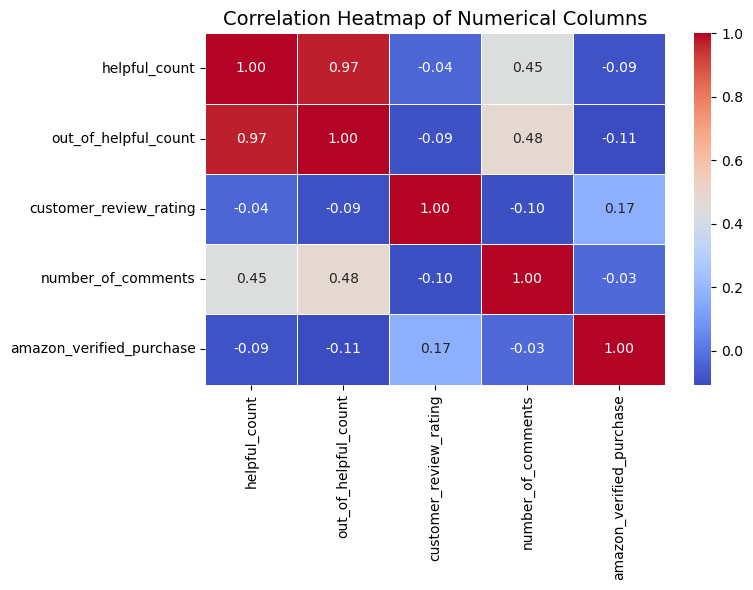

In [64]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Columns", fontsize=14)
plt.tight_layout()
# plt.savefig(f"{output_dir}/correlation_heatmap.pdf", format='pdf')
plt.show()


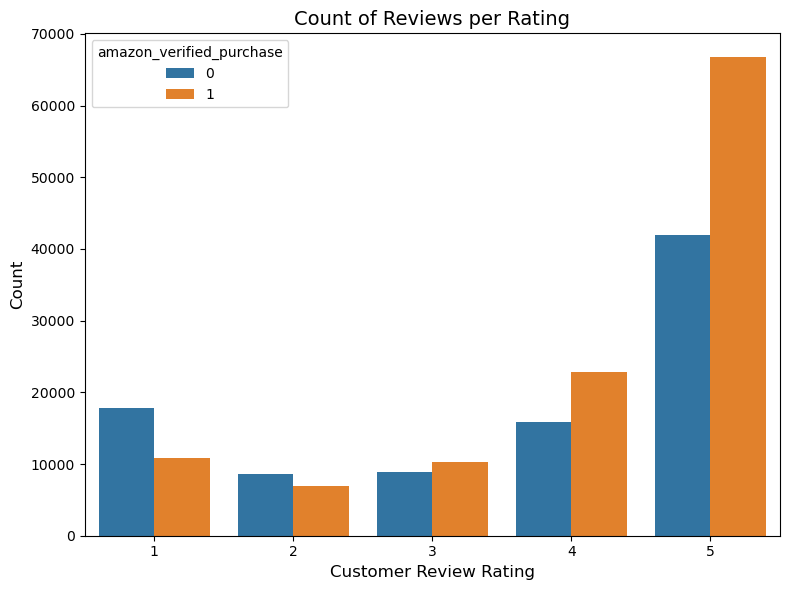

In [65]:
# Review Plot
plt.figure(figsize=(8, 6))
sns.countplot(x="customer_review_rating", hue="amazon_verified_purchase", data=df)
plt.title("Count of Reviews per Rating", fontsize=14)
plt.xlabel("Customer Review Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


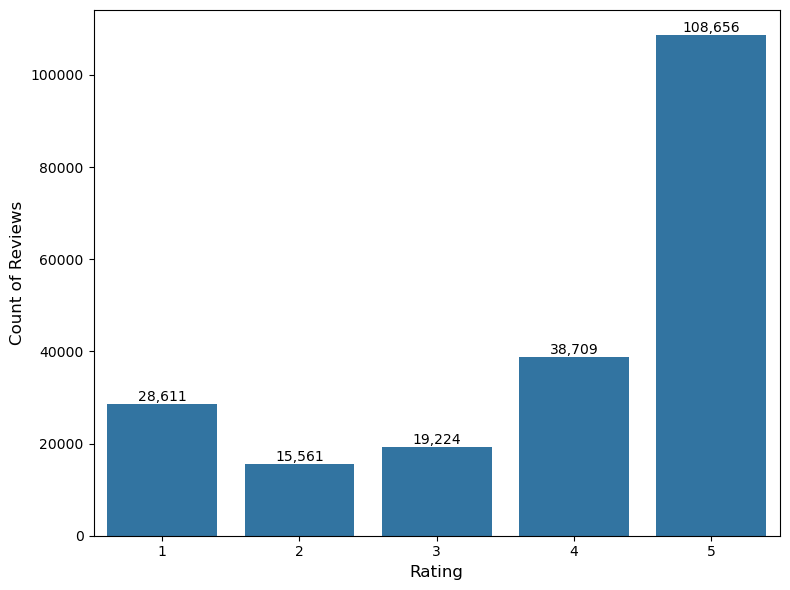

In [66]:
# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='customer_review_rating', data=df, order=sorted(df['customer_review_rating'].unique()))
ax.bar_label(ax.containers[0], fmt='{:,.0f}')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}/count_of_reviews_per_rating.pdf", format='pdf')
plt.show()

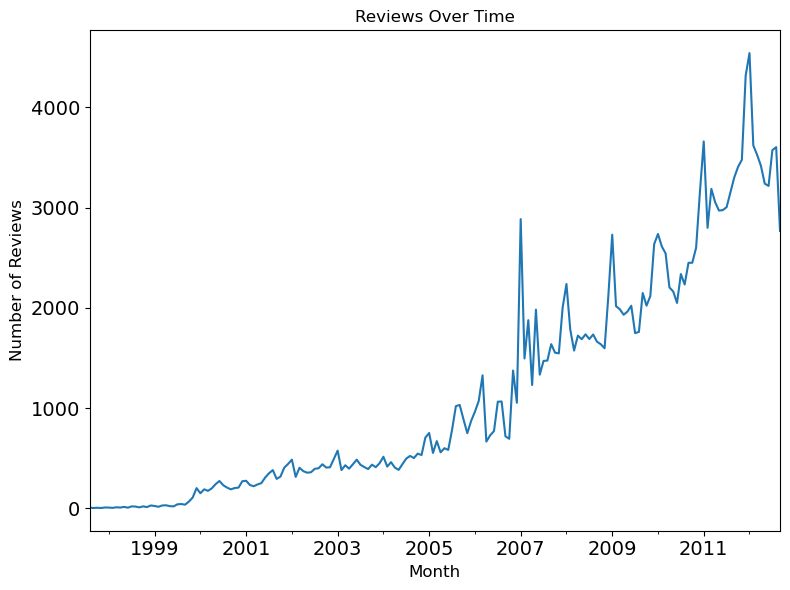

In [67]:
# Reviews over time
reviews_over_time = df.groupby(df['review_written_date'].dt.to_period('M')).size()
plt.figure(figsize=(8, 6))
reviews_over_time.plot(kind='line', title='Reviews Over Time', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.tight_layout()
plt.show()

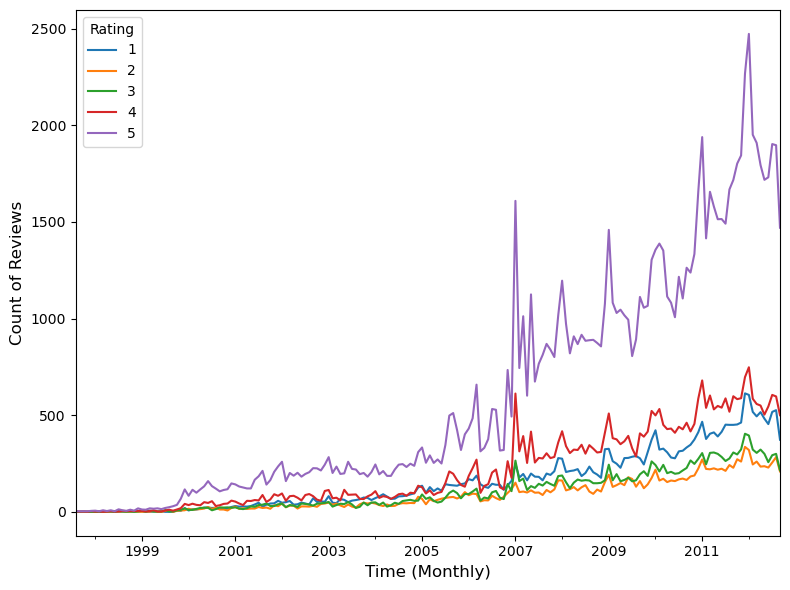

In [68]:
# Plot Reviews over time with individual ratings
reviews_over_time_ratings = df.groupby([df['review_written_date'].dt.to_period('M'), 'customer_review_rating']).size().unstack(fill_value=0)
plt.figure(figsize=(8, 6))
reviews_over_time_ratings.plot(kind='line', ax=plt.gca())
plt.xlabel('Time (Monthly)', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.legend(title='Rating')
plt.tight_layout()
plt.savefig(f"{output_dir}/reviews_over_time_ratings.pdf", format='pdf')
plt.show()

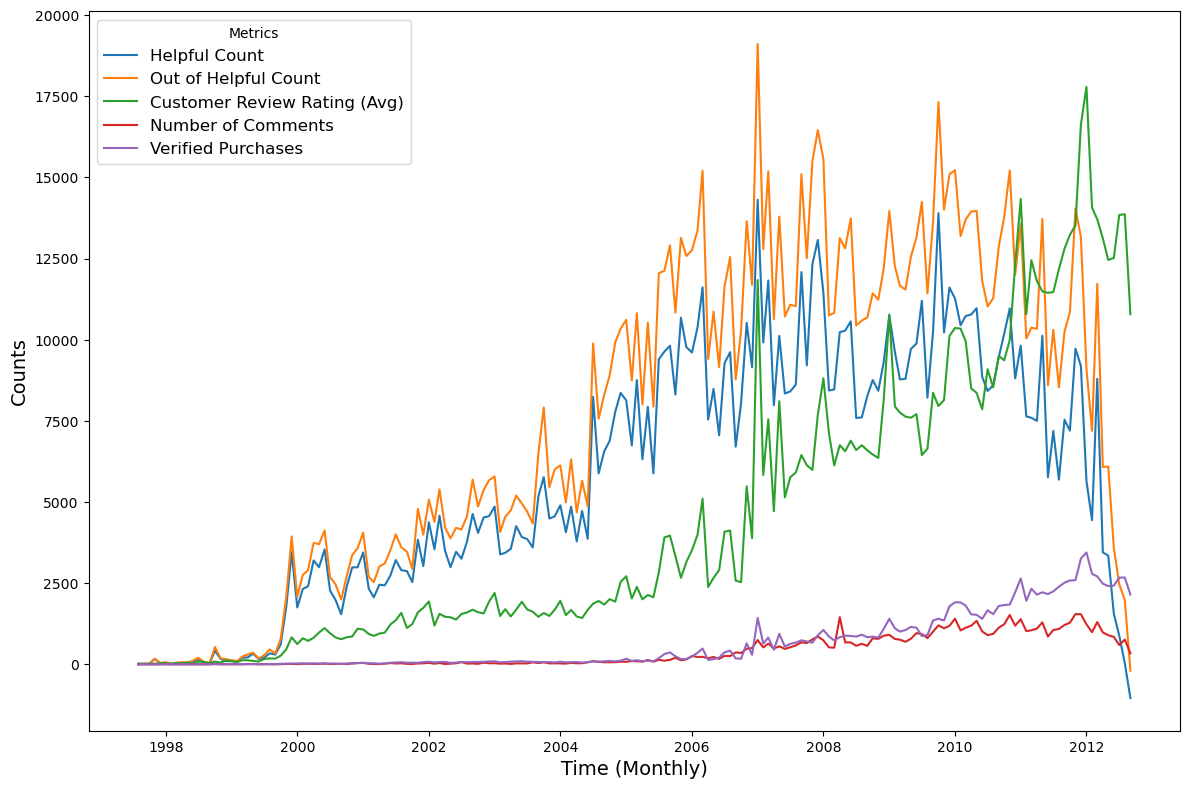

In [69]:
# Group data by 'review_written_date' and aggregate by sum/mean for numerical columns
trends = df.groupby(df['review_written_date'].dt.to_period('M')).agg({
    'helpful_count': 'sum',
    'out_of_helpful_count': 'sum',
    'customer_review_rating': 'sum',
    'number_of_comments': 'sum',
    'amazon_verified_purchase': 'sum'
}).reset_index()

# Convert period back to datetime for plotting
trends['review_written_date'] = trends['review_written_date'].dt.to_timestamp()

# Plot the trends
plt.figure(figsize=(12, 8))
plt.plot(trends['review_written_date'], trends['helpful_count'], label='Helpful Count', marker='')
plt.plot(trends['review_written_date'], trends['out_of_helpful_count'], label='Out of Helpful Count', marker='')
plt.plot(trends['review_written_date'], trends['customer_review_rating'], label='Customer Review Rating (Avg)', marker='')
plt.plot(trends['review_written_date'], trends['number_of_comments'], label='Number of Comments', marker='')
plt.plot(trends['review_written_date'], trends['amazon_verified_purchase'], label='Verified Purchases', marker='')

# Customize the plot
# plt.title('Review Trends Over Time', fontsize=16)
plt.xlabel('Time (Monthly)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(title='Metrics', fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}/review_trends_over_time.pdf", format='pdf')

# Show plot
plt.show()

In [73]:
# Ensure the reviews column is present
if 'review_text' not in df.columns:
    raise ValueError("The dataset must contain a 'review_text' column.")

# Calculate review lengths in words
df['word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Calculate statistics
shortest_length = df['word_count'].min()
median_length = df['word_count'].median()
longest_length = df['word_count'].max()

# Get the actual reviews for shortest and longest
shortest_review = df.loc[df['word_count'].idxmin(), 'review_text']
longest_review = df.loc[df['word_count'].idxmax(), 'review_text']

# Print the results
print(f"Shortest Review Length: {shortest_length} words")
print(f"Median Review Length: {median_length} words")
print(f"Longest Review Length: {longest_length} words")
print("\nShortest Review Text:")
print(shortest_review)
print("\nLongest Review Text:")
print(longest_review)

Shortest Review Length: 1 words
Median Review Length: 85.0 words
Longest Review Length: 4553 words

Shortest Review Text:
excellent

Longest Review Text:
This is interesting.  My first TX7 produced significant flare in backlit scenes.  Flare creates milky areas or streaks in the image, and is caused by stray light bouncing around inside the lens.  Very difficult, if not impossible, to correct in editing.\n\nI didn\'t know if this was something inherent in the lens design or whether I just got a defective camera.  So I bought a second TX7 and ran side-by-side comparisons.  The first continued to show flaring, the second did not.  So when you read a review that says "This camera takes awful pictures!" there may be nothing wrong with the camera design--the person probably just got a bad one, like I did.  (BTW, the return of the first TX7 couldn\'t have been easier.  Amazon sent a UPS truck to pick it up at my home, free of charge.  No wonder it\'s a successful company.)\n\nPROS:\n\nExcell

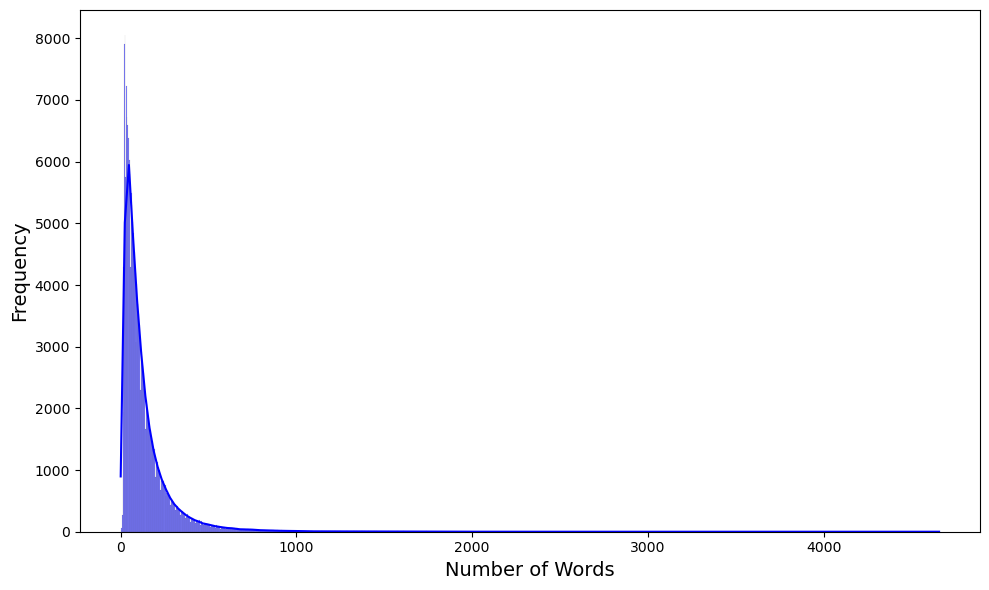

In [81]:
# Ensure the reviews column is present
if 'review_text' not in df.columns:
    raise ValueError("The dataset must contain a 'review_text' column.")

# Calculate review lengths in words
df['word_count'] = df['review_text_cleaned'].apply(lambda x: len(str(x).split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], kde=True, color='blue')
# plt.title('Distribution of Review Lengths (in Words)', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
# plt.savefig(f"{output_dir}/distribution_of_review_lengths.pdf", format='pdf')
plt.show()

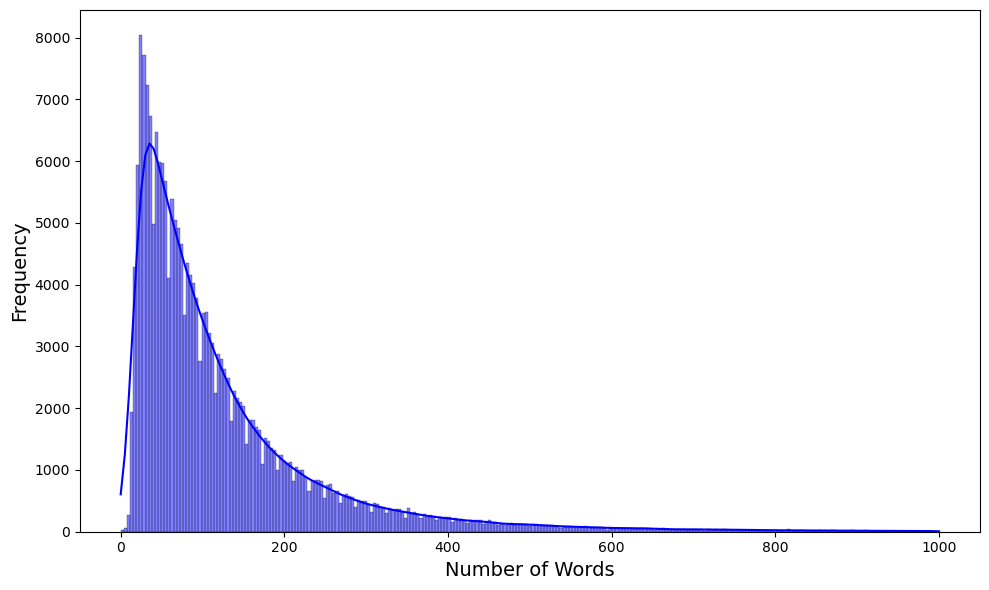

In [82]:
# Ensure the reviews column is present
if 'review_text' not in df.columns:
    raise ValueError("The dataset must contain a 'review_text' column.")

# Calculate review lengths in words
df['word_count'] = df['review_text_cleaned'].apply(lambda x: len(str(x).split()))

# Filter for word counts up to 1000 words
filtered_df = df[df['word_count'] <= 1000]

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['word_count'], kde=True, color='blue')
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
# plt.savefig(f"{output_dir}/distribution_of_review_lengths_filtered.pdf", format='pdf')
plt.show()


C:\Users\roman\AppData\Local\Temp\ipykernel_31764\3745292323.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


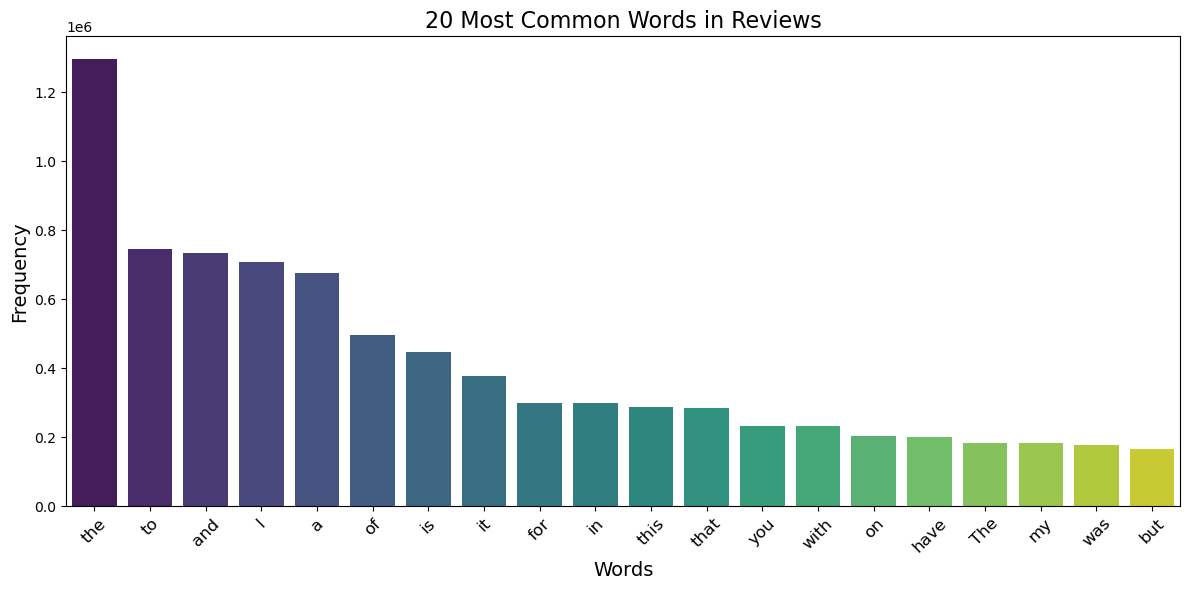

In [83]:
# Tokenize words and count frequencies
all_words = ' '.join(df['review_text_cleaned']).split()
word_counts = Counter(all_words)

# Get the 20 most common words
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

# Plot the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('20 Most Common Words in Reviews', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\roman\AppData\Local\Temp\ipykernel_31764\280147749.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


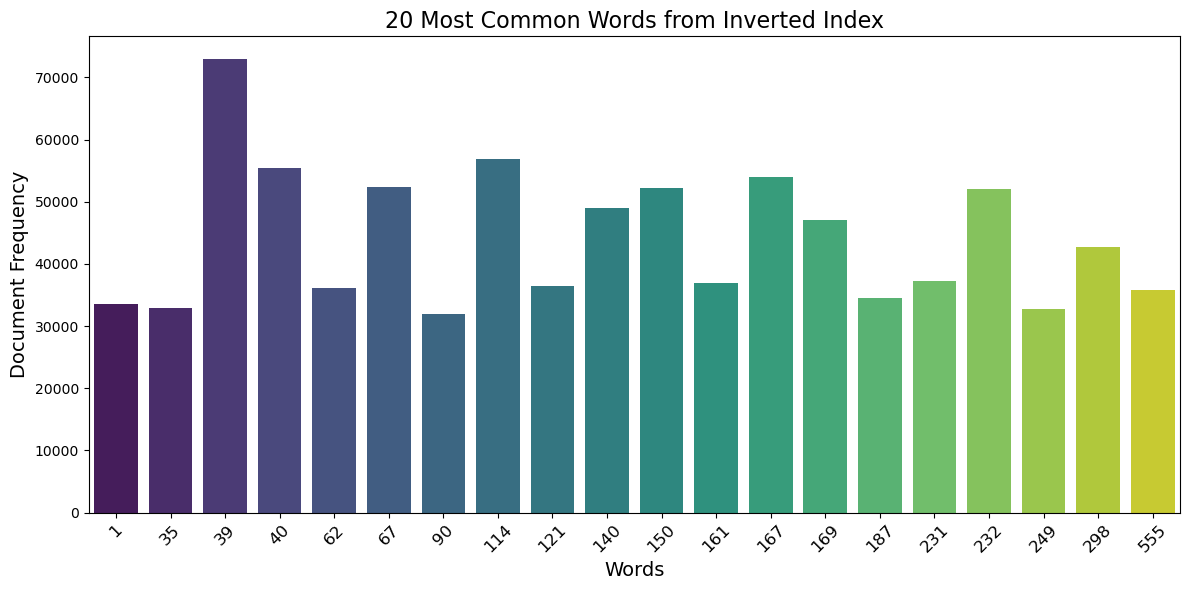

In [88]:
# Load the inverted index
with open("../index/inverted_index.pkl", "rb") as f:
    inverted_index = pickle.load(f)

# Calculate word frequencies from the inverted index
# Assuming the inverted index is a dictionary: {word: [list_of_doc_ids]}
word_counts = {word: len(doc_ids) for word, doc_ids in inverted_index.items()}

# Get the 20 most common words
common_words = Counter(word_counts).most_common(20)
words, counts = zip(*common_words)

# Plot the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('20 Most Common Words from Inverted Index', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Document Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\roman\AppData\Local\Temp\ipykernel_31764\1993646167.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=list(counts), palette='viridis')


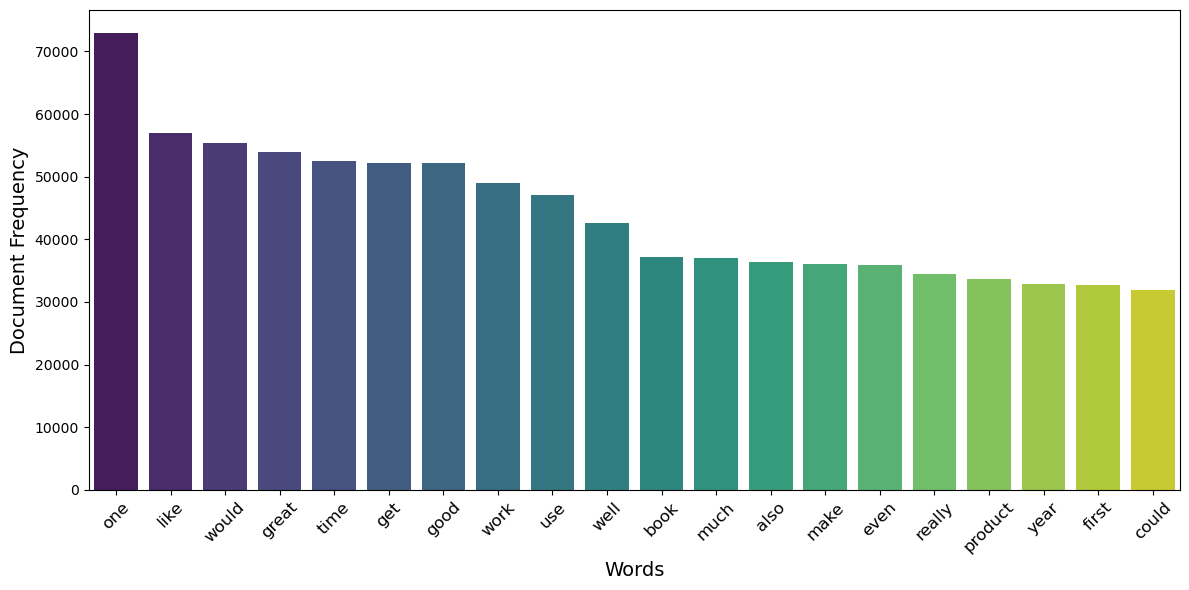

In [93]:
# Load the inverted index and term-to-ID mapping
with open("../index/inverted_index.pkl", "rb") as f:
    inverted_index = pickle.load(f)

with open("../index/id_to_term.pkl", "rb") as f:  # Assuming this file maps IDs to actual terms
    id_to_term = pickle.load(f)

# Calculate word frequencies from the inverted index
# Assuming the inverted index is a dictionary: {word_id: [list_of_doc_ids]}
word_counts = {word_id: len(doc_ids) for word_id, doc_ids in inverted_index.items()}

# Get the 20 most common words
common_words = Counter(word_counts).most_common(20)
word_ids, counts = zip(*common_words)  # Unpack word IDs and their counts

# Map IDs back to their actual terms
words = [id_to_term[word_id] for word_id in word_ids]

# Plot the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=list(counts), palette='viridis')
# plt.title('20 Most Common Words from Inverted Index', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Document Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.savefig(f"{output_dir}/20_most_common_words_inverted_index.pdf", format='pdf')
plt.show()

## Inverted Index

In [9]:
# Paths for output files
output_dir = "../index"
# os.makedirs(output_dir, exist_ok=True)

# Initialize NLTK tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [28]:
# Initialize components
postings_list = []
term_to_id = {}
id_to_term = {}
term_freq = defaultdict(int)
current_id = 1

# Additional statistics
stats = {
    "total_words": 0,
    "alphabetic_words": 0,
    "numeric_words": 0,
    "stopwords": 0,
    "lemmatized_words": 0
}

In [29]:
# Process reviews to build postings list and term mappings
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Reviews"):
    doc_id = row["doc_id"]
    words = nltk.word_tokenize(row["review_text_cleaned"].lower())

    for word in words:
        stats["total_words"] += 1
        if word.isalpha():
            stats["alphabetic_words"] += 1

        if word.isdigit():
            stats["numeric_words"] += 1
            
        if word in stop_words:
            stats["stopwords"] += 1

        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            stats["lemmatized_words"] += 1
            if lemma not in term_to_id:
                term_to_id[lemma] = current_id
                id_to_term[current_id] = lemma
                current_id += 1
            term_id = term_to_id[lemma]
            postings_list.append((term_id, doc_id))
            term_freq[term_id] += 1

Processing Reviews: 100%|██████████| 210761/210761 [02:59<00:00, 1175.11it/s]


In [30]:
# Sort the postings list
postings_list = sorted(postings_list, key=lambda x: (x[0], x[1]))

In [31]:
# Postings List with Terms (Sorted by Term and Document ID)
postings_list_terms = [
    {"Term": id_to_term[term_id], "Document ID": doc_id}
    for term_id, doc_id in postings_list
]

# Sort the postings_list_terms explicitly by Term and Document ID before saving
postings_list_terms_df = pd.DataFrame(postings_list_terms)
postings_list_terms_df = postings_list_terms_df.sort_values(by=["Term", "Document ID"], ascending=[True, True])

# Save to CSV
postings_list_terms_df.to_csv(f"{output_dir}/postings_list_with_terms.csv", index=False)

print("Postings list with terms saved and sorted successfully.")

Postings list with terms saved and sorted successfully.


In [32]:
# Build the inverted index from the sorted postings list
inverted_index = defaultdict(list)
for term_id, doc_id in postings_list:
    if not inverted_index[term_id] or inverted_index[term_id][-1] != doc_id:
        inverted_index[term_id].append(doc_id)

In [33]:
# Save Pickle Files
with open(f"{output_dir}/inverted_index.pkl", "wb") as f:
    pickle.dump(dict(inverted_index), f)
with open(f"{output_dir}/term_to_id.pkl", "wb") as f:
    pickle.dump(term_to_id, f)
with open(f"{output_dir}/id_to_term.pkl", "wb") as f:
    pickle.dump(id_to_term, f)
with open(f"{output_dir}/postings_list.pkl", "wb") as f:
    pickle.dump(postings_list, f)
with open(f"{output_dir}/term_freq.pkl", "wb") as f:
    pickle.dump(term_freq, f)
with open(f"{output_dir}/stats.pkl", "wb") as f:
    pickle.dump(stats, f)

In [34]:
# Save CSV Files
# Inverted Index with Terms (Sorted by Term)
inverted_index_terms = [
    {"Term": id_to_term[term_id], "Document IDs": ", ".join(map(str, doc_ids))}
    for term_id, doc_ids in sorted(inverted_index.items(), key=lambda x: id_to_term[x[0]])
]
pd.DataFrame(inverted_index_terms).to_csv(f"{output_dir}/inverted_index_with_terms.csv", index=False)

# Postings List with Terms (Sorted by Term and Document ID)
postings_list_terms = [
    {"Term": id_to_term[term_id], "Document ID": doc_id}
    for term_id, doc_id in postings_list
]
pd.DataFrame(postings_list_terms).to_csv(f"{output_dir}/postings_list_with_terms.csv", index=False)

# Save Statistics
pd.DataFrame(stats.items(), columns=["Metric", "Count"]).to_csv(f"{output_dir}/stats.csv", index=False)

print("Indexing files and statistics saved successfully.")

Indexing files and statistics saved successfully.


In [35]:
import sys
print(f"Total unique terms in inverted index: {len(inverted_index):,}")
memory_size_bytes = sys.getsizeof(inverted_index)
memory_size_mb = memory_size_bytes / (1024 ** 2)
print(f"Memory size of inverted index: {memory_size_bytes:,} bytes ({memory_size_mb:.2f} MB)")

Total unique terms in inverted index: 157,361
Memory size of inverted index: 5,242,968 bytes (5.00 MB)


In [36]:
print("Total words:", stats["total_words"])
print("Alphabetic words:", stats["alphabetic_words"])
print("Numeric words:", stats["numeric_words"])
print("Stopwords:", stats["stopwords"])
print("Lemmatized words:", stats["lemmatized_words"])

Total words: 31036763
Alphabetic words: 27001238
Numeric words: 277406
Stopwords: 13675592
Lemmatized words: 13325647


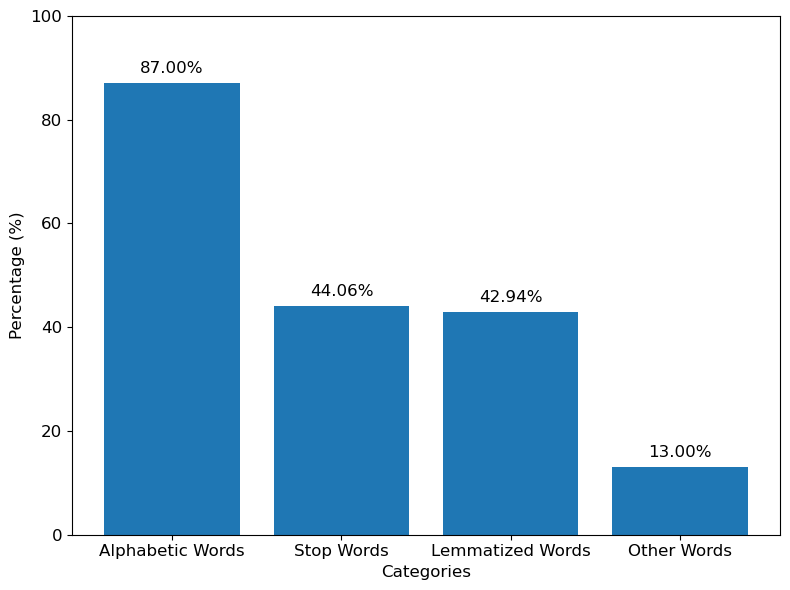

In [136]:
# Calculate percentages for the plot
total = stats["total_words"]
percentages = {
    "Alphabetic Words": (stats["alphabetic_words"] / total) * 100,
    "Stop Words": (stats["stopwords"] / total) * 100,
    "Lemmatized Words": (stats["lemmatized_words"] / total) * 100,
    "Other Words": ((total - stats["alphabetic_words"]) / total) * 100
}

categories = list(percentages.keys())
percentages_values = list(percentages.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, percentages_values)
# plt.title("Word Statistics Distribution (Percentage)", fontsize=14)
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.ylim(0, 100)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with values
for i, percentage in enumerate(percentages_values):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', fontsize=12, color="black")
plt.tight_layout()
plt.savefig(f"{output_dir}/word_statistics_distribution.png")
plt.show()

## Topics

In [40]:
# Load topics from topics.txt
topics_file = '../data/topics.txt'
with open(topics_file, 'r') as file:
    topics = file.readlines()

In [41]:
# Parse topics into a dictionary
topics_dict = {}
for line in topics:
    topic_number, topic_keywords = line.split('.', 1)
    topics_dict[int(topic_number.strip().split()[1])] = topic_keywords.strip().split(', ')

In [42]:
# List out the topics
print("Topics Dictionary:")
for topic_number, keywords in topics_dict.items():
    print(f"Topic {topic_number}: {', '.join(keywords)}")

Topics Dictionary:
Topic 1: video, dvd, player, tv, quality, hd, sony, disc, media, picture, videos, audio, play, record, dvds, recording, blu-ray, mp3, format, digital, discs, movies, burn, copy, hdmi, standard, samsung, watch, tape, set, players, using, able, dvd's, watching, netflix, recorder, panasonic, home, youtube, ray, vhs, features, fine, disks, receiver, files, tapes, channels, capture, camcorder, playback, tivo, cable, recorded, content, transfer, burning, onto, box, editing, 3d, itunes, feature, channel, disk, clips, streaming, cds, input, center, output, 1080p, convert, hdtv, regular, vcr, analog, plays, component, burned, stream, hooked, blu, included, dvr, edit, toshiba, viewing, definition, tuner, lg, cd, zune, option, available, source, studio, plus, music, playing, played, television, directly, burner, widescreen, inputs, pinnacle, footage, via, cd's, formats, vegas, bluray, recordings, records, converter, roxio, titles, skip, nero, theater, including, conversion, reg

## Semantic Search with BERT Embeddings ! Run in colab. Don't use for now

In [ ]:
# # Load the tokenizer and model
# model_name = "bert-base-uncased"  # Replace with your specific model name
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# embedding_model = AutoModel.from_pretrained(model_name)

In [ ]:
# # Define the maximum sequence length
# MAX_SEQ_LENGTH = 512

# def get_embedding(text):
#     # Tokenize and truncate the text
#     inputs = tokenizer(
#         text,
#         max_length=MAX_SEQ_LENGTH,
#         padding="max_length",
#         truncation=True,
#         return_tensors="pt"  # PyTorch tensors
#     )
    
#     # Pass through the model
#     with torch.no_grad():
#         outputs = embedding_model(**inputs)
    
#     # Use the last hidden state and calculate the mean embedding
#     embeddings = outputs.last_hidden_state
#     return embeddings.mean(dim=1).squeeze().numpy()

### This made my computer work. We might want to run this in colab.

For now it is commented out

In [ ]:
# Compute embeddings for all documents
# embeddings = np.array([get_embedding(text) for text in tqdm(df["review_text"].fillna(""), desc="Generating Embeddings")])

In [ ]:
# # Save embeddings
# np.save(f"{output_dir}/embeddings.npy", embeddings)
# print("Document embeddings saved.")

## Boolean Search

In [10]:
import pandas as pd
import pickle
import tkinter as tk
from collections import defaultdict

In [11]:
# Load the document data (adjust the path as needed)
df = pd.read_pickle("../data/reviews_segment_processed.pkl")

In [12]:
# Load inverted index from Pickle file (optimized loading)
with open("../index/inverted_index.pkl", "rb") as f:
    inversed_index = pickle.load(f)
with open("../index/term_to_id.pkl", "rb") as f:
    term_to_id = pickle.load(f)

In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_terms(terms):
    return [lemmatizer.lemmatize(term) for term in terms]

In [14]:
# Boolean search helper functions
def intersect(p1, p2):
    answer = []
    i, j = 0, 0
    while i < len(p1) and j < len(p2):
        if p1[i] == p2[j]:
            answer.append(p1[i])
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            i += 1
        else:
            j += 1
    return answer

def union(p1, p2):
    return sorted(set(p1).union(set(p2)))

def boolean_search(aspect1, aspect2, opinion, method):
    min_length = 2
    # Filter terms based on minimum length
    aspect1 = aspect1 if len(aspect1) >= min_length else None
    aspect2 = aspect2 if len(aspect2) >= min_length else None
    opinion = opinion if len(opinion) >= min_length else None

    # Remove None values before searching
    terms = [t for t in [aspect1, aspect2, opinion] if t]

    # Lemmatize query terms
    aspect1, aspect2, opinion = lemmatize_terms([aspect1, aspect2, opinion])

    # Convert terms to their respective term IDs
    aspect1_id = term_to_id.get(aspect1.lower())
    aspect2_id = term_to_id.get(aspect2.lower())
    opinion_id = term_to_id.get(opinion.lower())

    # Retrieve document IDs from the inverted index
    aspect1_docs = set(inversed_index.get(aspect1_id, []))
    aspect2_docs = set(inversed_index.get(aspect2_id, []))
    opinion_docs = set(inversed_index.get(opinion_id, []))

    # Perform Boolean operations based on the selected method
    if method == "method1":
        # OR operation on everything
        result_docs = aspect1_docs.union(aspect2_docs).union(opinion_docs)
    elif method == "method2":
        # AND operation on everything
        result_docs = aspect1_docs.intersection(aspect2_docs).intersection(opinion_docs)
    elif method == "method3":
        # OR on aspects, AND with opinion
        aspect_docs = aspect1_docs.union(aspect2_docs)
        result_docs = aspect_docs.intersection(opinion_docs)
    else:
        print("Invalid method.")
        return []        
    return result_docs

In [120]:
# Testing Boolean Search
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method1 = "method1" # OR operation on all terms
method2 = "method2" # AND operation on all terms
method3 = "method3" # OR on aspects, AND with opinion

results_m1 = boolean_search(query_aspect1, query_aspect2, query_opinion, method1)
results_m2 = boolean_search(query_aspect1, query_aspect2, query_opinion, method2)
results_m3 = boolean_search(query_aspect1, query_aspect2, query_opinion, method3)


print(f"Results: {len(results_m1)}")
print(f"Results: {len(results_m2)}")
print(f"Results: {len(results_m3)}")

Results: 25618
Results: 128
Results: 1558


In [122]:
# Convert the set of document IDs to a DataFrame
results_m2_df = df[df['doc_id'].isin(results_m2)]

# Print the 'review_text_cleaned' column
print(results_m2_df['review_text_cleaned'])

4053      Well, the concept is great. The visual and aud...
8050      I traded in my trusty Handspring Visor Pro of ...
9863      If you were a fan of Anthrax between 1985 and ...
10623     After having read many of the reviews about th...
12090     I won't belabor the commentsreviews left by ot...
                                ...                        
197036    In terms of compactness and design Sony has do...
202702    I've been using this drive for about three mon...
203645    This DVD is basically a guide to taking correc...
205714    I gave the TuneCast a generous two stars, beca...
210540    Well, I must disagree with reviewer Alydes who...
Name: review_text_cleaned, Length: 128, dtype: object


## Boolean Search with Ratings Filter

In [49]:
# Load Data
# df = pd.read_pickle("../data/reviews_segment_processed.pkl")

In [16]:
def load_opinion_lexicon():
    """
    Load the positive and negative opinion words from the lexicon files.
    Handles files with non-UTF-8 encodings gracefully.
    """
    positive_words_file = "../opinion-lexicon-English/positive-words.txt"
    negative_words_file = "../opinion-lexicon-English/negative-words.txt"

    # Use 'latin-1' or 'ISO-8859-1' encoding to handle non-UTF-8 characters
    with open(positive_words_file, "r", encoding="latin-1") as f:
        positive_words = set(line.strip() for line in f if not line.startswith(";") and line.strip())

    with open(negative_words_file, "r", encoding="latin-1") as f:
        negative_words = set(line.strip() for line in f if not line.startswith(";") and line.strip())

    return positive_words, negative_words

In [17]:
# Load the lexicon
positive_words, negative_words = load_opinion_lexicon()

In [18]:
print(f"Loaded {len(positive_words)} positive words and {len(negative_words)} negative words.")
print(f"Sample positive words: {list(positive_words)[:5]}")
print(f"Sample negative words: {list(negative_words)[:5]}")

Loaded 2006 positive words and 4783 negative words.
Sample positive words: ['amazement', 'honoring', 'revives', 'respectable', 'large-capacity']
Sample negative words: ['admonish', 'infraction', 'ding', 'guilty', 'dehumanization']


In [19]:
def determine_opinion_sentiment(opinion):
    """
    Determine the sentiment of the opinion using the opinion lexicon.
    Args:
        opinion (str): The opinion term or phrase from the query.
    Returns:
        str: 'Positive', 'Negative', or 'Neutral'
    """
    opinion_words = opinion.lower().split()
    if any(word in positive_words for word in opinion_words):
        return "Positive"
    elif any(word in negative_words for word in opinion_words):
        return "Negative"
    else:
        return "Neutral"


In [20]:
df["sentiment_label"] = df["review_text_cleaned"].apply(determine_opinion_sentiment)

In [21]:
def boolean_rating_search(aspect1, aspect2, opinion, method):
    """
    Perform Boolean search considering sentiment and rating.

    Args:
        aspect1 (str): First aspect in the query.
        aspect2 (str): Second aspect in the query.
        opinion (str): Opinion in the query.
        method (str): Search method (method1, method2, or method3).
        df (DataFrame): DataFrame with reviews.

    Returns:
        DataFrame: Filtered results.
    """
    
    # Perform the Boolean search to get matching document IDs (this will be based on your previous implementation)
    matching_docs = boolean_search(aspect1, aspect2, opinion, method)  # This should return a list of doc_ids

    # Get matched reviews
    matched_df = df[df['doc_id'].isin(matching_docs)]

    # Determine sentiment based on the query's opinion term
    sentiment_label = determine_opinion_sentiment(opinion)
    # print(f"Detected sentiment: {sentiment_label}")

    # Apply filtering based on sentiment and rating
    if sentiment_label == "Positive":
        filtered_df = matched_df[
            (matched_df["customer_review_rating"] > 3) & 
            (matched_df["sentiment_label"] == "Positive")
        ]
    elif sentiment_label == "Negative":
        filtered_df = matched_df[
            (matched_df["customer_review_rating"] <= 3) & 
            (matched_df["sentiment_label"] == "Negative")
        ]
    else:  # If sentiment is neutral or unknown, return all matching docs without rating filtering
        filtered_df = matched_df[
            (matched_df["customer_review_rating"] >= 1)
        ]

    return filtered_df

In [22]:
# Testing Boolean Search
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method1 = "method1" # OR operation on all terms
method2 = "method2" # AND operation on all terms
method3 = "method3" # OR on aspects, AND with opinion

results_m1 = boolean_rating_search(query_aspect1, query_aspect2, query_opinion, method1)
results_m2 = boolean_rating_search(query_aspect1, query_aspect2, query_opinion, method2)
results_m3 = boolean_rating_search(query_aspect1, query_aspect2, query_opinion, method3)


print(f"Results: {len(results_m1)}")
print(f"Results: {len(results_m2)}")
print(f"Results: {len(results_m3)}")

Results: 418
Results: 3
Results: 74


In [57]:
pd.set_option('display.max_colwidth', 200)
print(results_m2['review_text_cleaned'])

33724     I planned to subscribe to XM Radio. But after reading the review by FOX, I decided not to subscribe based on the fact that XM lowered the audio quality after Apr 2006 by adding more channels. If y...
158371    The major problem of this product is the audio quality. It's simply poor when used within the local network, and totally useless if you try to use it over the Internet even with high speed cable c...
178818                                                                                                                 In addition to the poor audio quality, I hadn't remembered the Weavers sounding so syrupy.
Name: review_text_cleaned, dtype: object


## Similarity Scoring

### Create Scoring

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pickle
import os

In [59]:
# Load the dataset
df = pd.read_pickle("../data/reviews_segment_processed.pkl")

In [24]:
# Directory to save the TF-IDF artifacts
output_dir = "../scoring"
os.makedirs(output_dir, exist_ok=True)

In [25]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(df["review_text_cleaned"].fillna(""))

In [62]:
# Save TF-IDF vectorizer and matrix
with open(f"{output_dir}/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
with open(f"{output_dir}/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)
print("TF-IDF files saved.")

TF-IDF files saved.


In [63]:
# Print basic info about the TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of terms: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF matrix shape: (210761, 196803)
Number of terms: 196803


### Load Created Matrix

In [26]:
df = pd.read_pickle("../data/reviews_segment_processed.pkl")

In [27]:
# Load TF-IDF vectorizer and matrix
with open("../scoring/tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)
with open("../scoring/tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)
print("TF-IDF vectorizer and matrix loaded.")

TF-IDF vectorizer and matrix loaded.


In [28]:
# Verify that loaded objects are correct
assert hasattr(tfidf_vectorizer, "transform"), "tfidf_vectorizer is not a TfidfVectorizer object."
assert hasattr(tfidf_matrix, "shape"), "tfidf_matrix is not a valid sparse matrix."

In [29]:
def compute_similarity(query, tfidf_vectorizer, tfidf_matrix):
    """
    Compute semantic similarity between the query and the TF-IDF matrix.
    
    Args:
        query (str): Query string.
        tfidf_vectorizer (TfidfVectorizer): Pretrained TF-IDF vectorizer.
        tfidf_matrix (sparse matrix): Precomputed TF-IDF matrix.
        
    Returns:
        list: Similarity scores for each document in the TF-IDF matrix.
    """
    query_vector = tfidf_vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    return similarity_scores


In [30]:
def boolean_semantic_search(aspect1, aspect2, opinion, method):
    """
    Perform Boolean search and rank results by semantic similarity.
    
    Args:
        aspect1, aspect2, opinion (str): Query terms.
        method (str): Boolean search method ("method1", "method2", "method3").
        
    Returns:
        DataFrame: Results ranked by semantic similarity.
    """
    # Load the TF-IDF vectorizer and matrix
    output_dir = "../scoring"
    with open(f"{output_dir}/tfidf_vectorizer.pkl", "rb") as f:
        tfidf_vectorizer = pickle.load(f)
    with open(f"{output_dir}/tfidf_matrix.pkl", "rb") as f:
        tfidf_matrix = pickle.load(f)

    # Verify the types of loaded objects
    assert hasattr(tfidf_vectorizer, "transform"), "tfidf_vectorizer is not a TfidfVectorizer object."
    assert hasattr(tfidf_matrix, "shape"), "tfidf_matrix is not a valid sparse matrix."

    # Perform Boolean search to get matching docs
    matching_docs = boolean_search(aspect1, aspect2, opinion, method)
    
    # Filter DataFrame to matching docs
    matched_df = df[df["doc_id"].isin(matching_docs)].copy()
    
    # Combine query terms into a single string
    query = f"{aspect1} {aspect2} {opinion}"
    
    # Compute similarity scores for matched docs
    query_vector = tfidf_vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # Add similarity scores to the DataFrame
    matched_df["semantic_score"] = matched_df.index.map(lambda idx: similarity_scores[idx])
    
    # Filter by similarity threshold
    similarity_threshold=0.2
    matched_df = matched_df[matched_df["semantic_score"] >= similarity_threshold]

    # Sort by semantic score in descending order
    matched_df = matched_df.sort_values(by="semantic_score", ascending=False)
    
    return matched_df


In [31]:
# Testing Boolean Search
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method1 = "method1" # OR operation on all terms
method2 = "method2" # AND operation on all terms
method3 = "method3" # OR on aspects, AND with opinion

results_m1 = boolean_semantic_search(query_aspect1, query_aspect2, query_opinion, method1)
results_m2 = boolean_semantic_search(query_aspect1, query_aspect2, query_opinion, method2)
results_m3 = boolean_semantic_search(query_aspect1, query_aspect2, query_opinion, method3)


print(f"Results: {len(results_m1)}")
print(f"Results: {len(results_m2)}")
print(f"Results: {len(results_m3)}")

Results: 365
Results: 24
Results: 140


In [70]:
print(results_m2['review_text_cleaned'])

197036    In terms of compactness and design Sony has done a good job. But, the audio quality is poor. The sound has no bass and at high frequencies it begins to distort. We were very unsatisfied with the a...
158371    The major problem of this product is the audio quality. It's simply poor when used within the local network, and totally useless if you try to use it over the Internet even with high speed cable c...
156573    The song selection on this album is terrific. Some of his best songs are on this album. The only complaint I have is the sound quality. Maybe I have been listening to too many new CD's, but the au...
169197                                                                                              Pros Installed easily Good software bundle Cons Audio quality sometimes poor Remote control sometimes finicky
178818                                                                                                                 In addition to the poor audio quality, I 

## Laten Dirichlet Allocation

In [32]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
import pickle
import re

In [72]:
# Load the dataset
df = pd.read_pickle("../data/reviews_segment_processed.pkl")

In [33]:
# Directory to save LDA outputs
output_dir = "../lda"
os.makedirs(output_dir, exist_ok=True)

In [37]:
# Tokenization and Vectorization
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
doc_term_matrix = vectorizer.fit_transform(df["review_text_cleaned"].fillna(""))

In [75]:
# Save vocabulary
with open(f"{output_dir}/vocabulary.pkl", "wb") as f:
    pickle.dump(vectorizer.get_feature_names_out(), f)

### Train Model

In [76]:
num_topics = 50
lda_model = LatentDirichletAllocation(
    n_components=num_topics,
    random_state=42,
    max_iter=20,
    learning_method="online",
    batch_size=128,
)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=20,
                          n_components=50, random_state=42)

In [77]:
# Save LDA model
with open(f"{output_dir}/lda_model.pkl", "wb") as f:
    pickle.dump(lda_model, f)

### Per-Topic Word Distributions

In [34]:
# Load LDA model
with open(f"{output_dir}/lda_model.pkl", "rb") as f:
    lda_model = pickle.load(f)

print("LDA model loaded successfully.")

LDA model loaded successfully.


In [35]:
def display_topics(model, feature_names, no_top_words):
    """
    Display the top words in each topic from the LDA model.
    """
    topics_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics_dict[topic_idx] = top_features
    return topics_dict

In [38]:
# Extract topics
vocabulary = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, vocabulary, 10)

In [81]:
# Save topics to a file
with open(f"{output_dir}/topics.pkl", "wb") as f:
    pickle.dump(topics, f)

In [82]:
# Print topics for verification
print("Extracted Topics:")
for topic_id, words in topics.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

Extracted Topics:
Topic 0: help, best, view, does, point, make, experience, example, excellent, based
Topic 1: battery, device, works, small, use, fit, charge, size, plug, little
Topic 2: love, exactly, food, perfect, english, great, spanish, road, french, pan
Topic 3: box, model, clean, used, air, expensive, buying, problems, replace, buy
Topic 4: software, computer, use, tool, files, file, tools, computers, click, adobe
Topic 5: did, service, problem, got, new, support, amazon, customer, time, days
Topic 6: new, original, stand, say, truly, lack, missing, previous, years, come
Topic 7: drive, windows, pc, install, installed, mac, usb, software, work, new
Topic 8: reviews, purchase, issue, item, purchased, help, read, fix, instructions, says
Topic 9: clear, plastic, used, plan, job, close, smooth, luck, cheap, face
Topic 10: minutes, cost, 10, extra, 30, problem, times, right, small, left
Topic 11: brand, future, believe, clearly, date, reviewer, offer, simply, forget, write
Topic 12:

### Per-Document Topic Distributions

In [39]:
# Get per-document topic distributions
doc_topic_distributions = lda_model.transform(doc_term_matrix)

In [40]:
# Assign most probable topic to each document
df["dominant_topic"] = np.argmax(doc_topic_distributions, axis=1)
df["topic_distribution"] = doc_topic_distributions.tolist()

In [85]:
# Save the document-topic distribution
df.to_pickle(f"{output_dir}/document_topic_distribution.pkl")

### Query to Topic Matching

In [41]:
def match_query_to_topics(query, vectorizer, lda_model, vocabulary):
    """
    Match a query to the most relevant topics using the LDA model.
    """
    query_vector = vectorizer.transform([query])
    query_topic_distribution = lda_model.transform(query_vector).flatten()
    return query_topic_distribution

In [42]:
def retrieve_documents_by_topics(query_topic_distribution, doc_topic_distributions, threshold=0.1):
    """
    Retrieve documents based on their topic distribution similarity to the query.
    """
    matching_docs = []
    for doc_idx, doc_distribution in enumerate(doc_topic_distributions):
        similarity = np.dot(query_topic_distribution, doc_distribution)
        if similarity >= threshold:  # Adjust threshold as needed
            matching_docs.append(doc_idx)
    return matching_docs

### Topic Modeling Search

In [43]:
def topic_model_search(aspect1, aspect2, opinion, method, similarity_threshold=0.35):
    """
    Perform topic modeling search with filtering for relevance.

    Args:
        aspect1 (str): First aspect of the query.
        aspect2 (str): Second aspect of the query.
        opinion (str): Opinion or sentiment in the query.
        method (str): Boolean method ("method1", "method2", "method3").
        similarity_threshold (float): Minimum similarity score to consider a document relevant.

    Returns:
        DataFrame: Filtered results ranked by topic similarity.
    """
    # Combine query terms into a single query string
    query = f"{aspect1} {aspect2} {opinion}"
    
    # Match query to topics
    query_topic_distribution = match_query_to_topics(query, vectorizer, lda_model, vocabulary)
    
    # Retrieve relevant documents
    matching_doc_ids = retrieve_documents_by_topics(query_topic_distribution, doc_topic_distributions, threshold=similarity_threshold)
    
    # Filter DataFrame to include only matching documents
    results_df = df.iloc[matching_doc_ids].copy()
    
    # Add topic similarity scores for ranking
    results_df["topic_similarity"] = [
        np.dot(query_topic_distribution, doc_distribution)
        for doc_distribution in doc_topic_distributions[matching_doc_ids]
    ]
    
    # Further filter results by similarity threshold
    results_df = results_df[results_df["topic_similarity"] >= similarity_threshold]
    
    # Sort results by topic similarity
    results_df = results_df.sort_values(by="topic_similarity", ascending=False)
    
    return results_df

In [ ]:
# Testing Boolean Search
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method1 = "method1" # OR operation on all terms
method2 = "method2" # AND operation on all terms
method3 = "method3" # OR on aspects, AND with opinion

results_m1 = topic_model_search(query_aspect1, query_aspect2, query_opinion, method1)
results_m2 = topic_model_search(query_aspect1, query_aspect2, query_opinion, method2)
results_m3 = topic_model_search(query_aspect1, query_aspect2, query_opinion, method3)



print(f"Results: {len(results_m1)}")
print(f"Results: {len(results_m2)}")
print(f"Results: {len(results_m3)}")

Results: 9
Results: 9
Results: 9


In [90]:
print(results_m2['review_text_cleaned'])

121       I got this pair of headphones for my girlfriend. She was mostly looking for something decent sounding that was comfortable. These headphones don't fail to deliver there! However, I would place the...
167790                                                                          Awesome Quality for the Buck. Cancels noise very well, bass is top notch, and the durability of the ear bud so far has been good.
187716    The sound quality is very crisp, the pads are very comfortable can wear them for long periods. Since the bass is a bit too boosted on these, I still prefer my Audio Technica ATHM40fs for monitorin...
72021                                                       The S3 is a great little MP3 player, and this speaker system is not very good quality. It would be nice if they made a better system for this player.
80805           These earphones are very comfortable and the music quality is excellent. Can be worn when gardening and cleaning the house. No cords to get in t

C:\Users\roman\AppData\Local\Temp\ipykernel_14008\1411733484.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', num_topics)


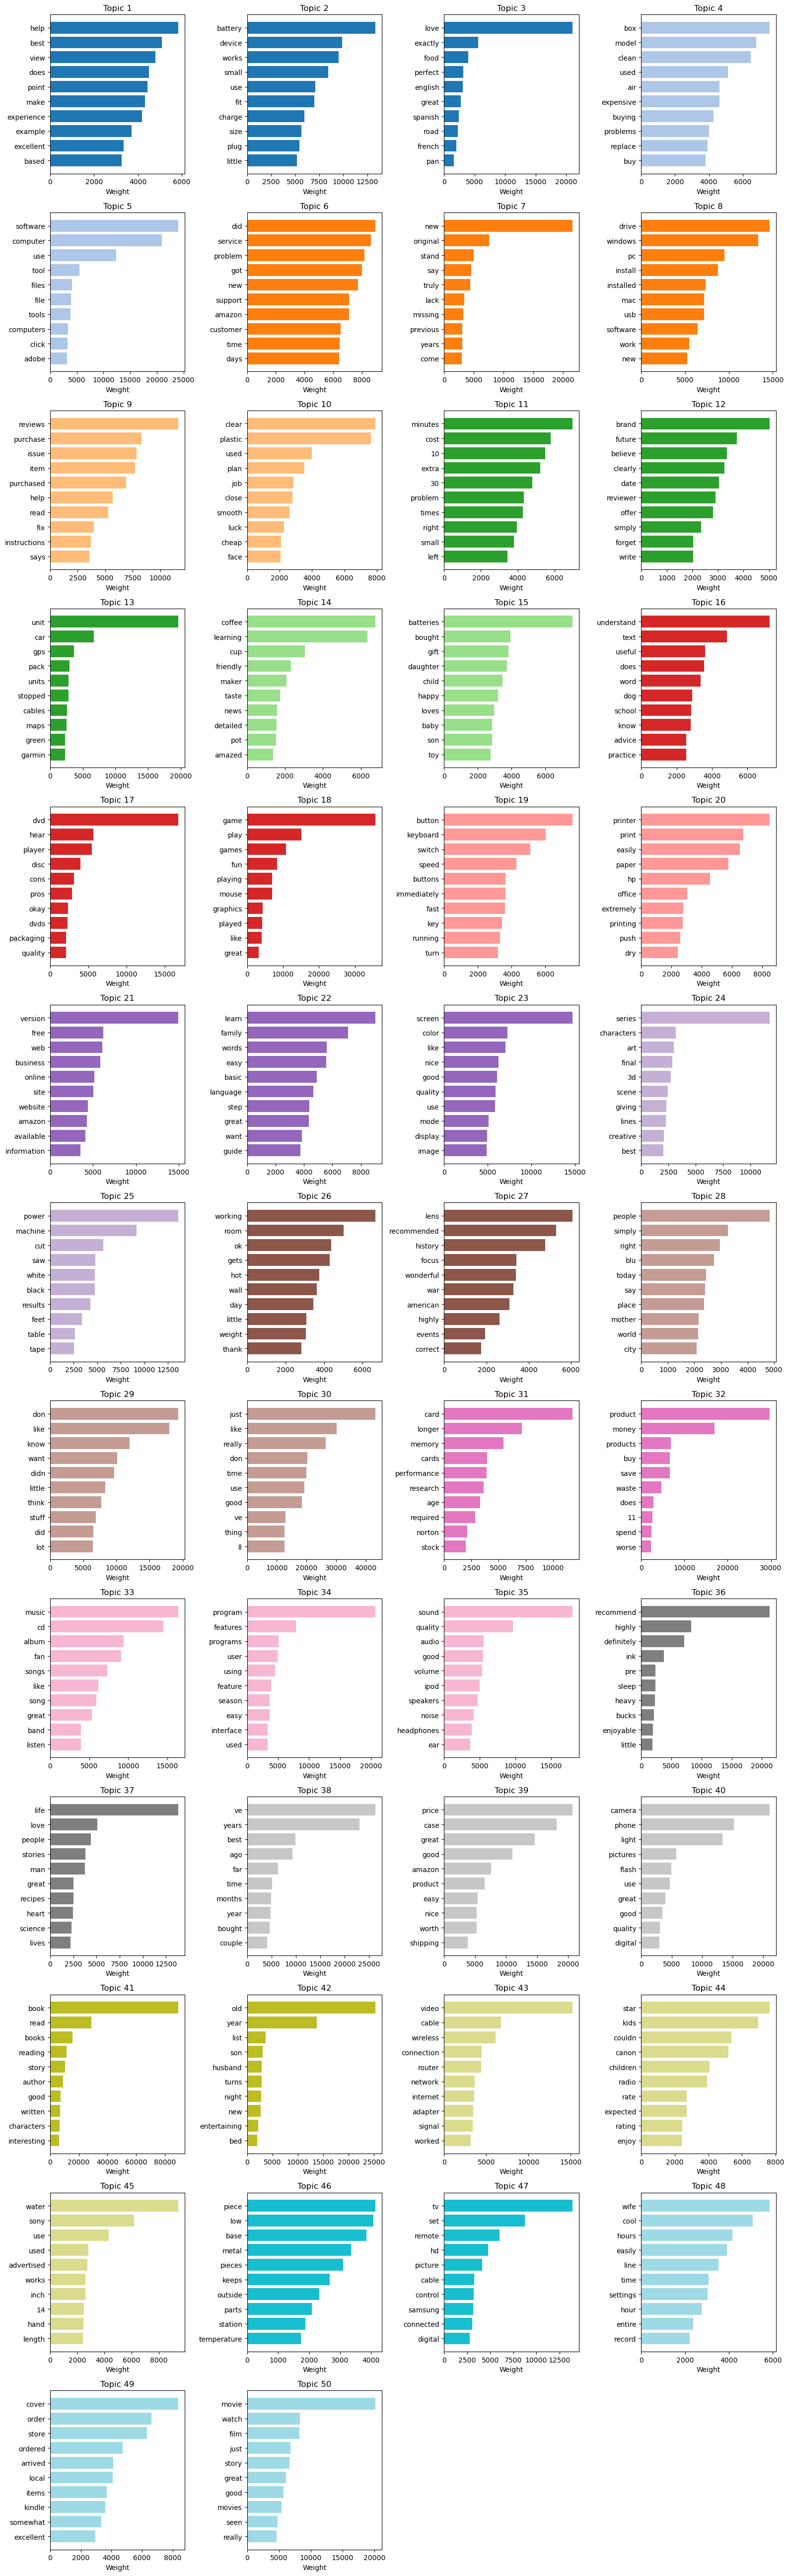

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

def plot_top_words_per_topic(lda_model, feature_names, num_topics=5, num_words=10):
    """
    Plot top words for each topic in a grid layout with unique colors for each plot.

    Args:
        lda_model: Trained LDA model.
        feature_names: List of feature names from the vectorizer.
        num_topics: Number of topics to display.
        num_words: Number of top words to display for each topic.
    """
    # Calculate the number of rows needed for 4 columns
    num_columns = 4
    num_rows = (num_topics + num_columns - 1) // num_columns

    # Create subplots with a grid layout
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, num_rows * 4), sharex=False, sharey=False)
    axes = axes.flatten()

    # Generate a colormap for unique colors
    colormap = cm.get_cmap('tab20', num_topics)

    for topic_idx, topic in enumerate(lda_model.components_[:num_topics]):
        top_words_indices = topic.argsort()[:-num_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        weights = topic[top_words_indices]

        # Assign a unique color to each topic
        color = colormap(topic_idx)

        axes[topic_idx].barh(top_words, weights, color=color)
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=12)
        axes[topic_idx].invert_yaxis()
        axes[topic_idx].set_xlabel("Weight", fontsize=10)

    # Hide any unused subplots
    for idx in range(num_topics, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

# Example Usage:
plot_top_words_per_topic(lda_model, vocabulary, num_topics=50, num_words=10)


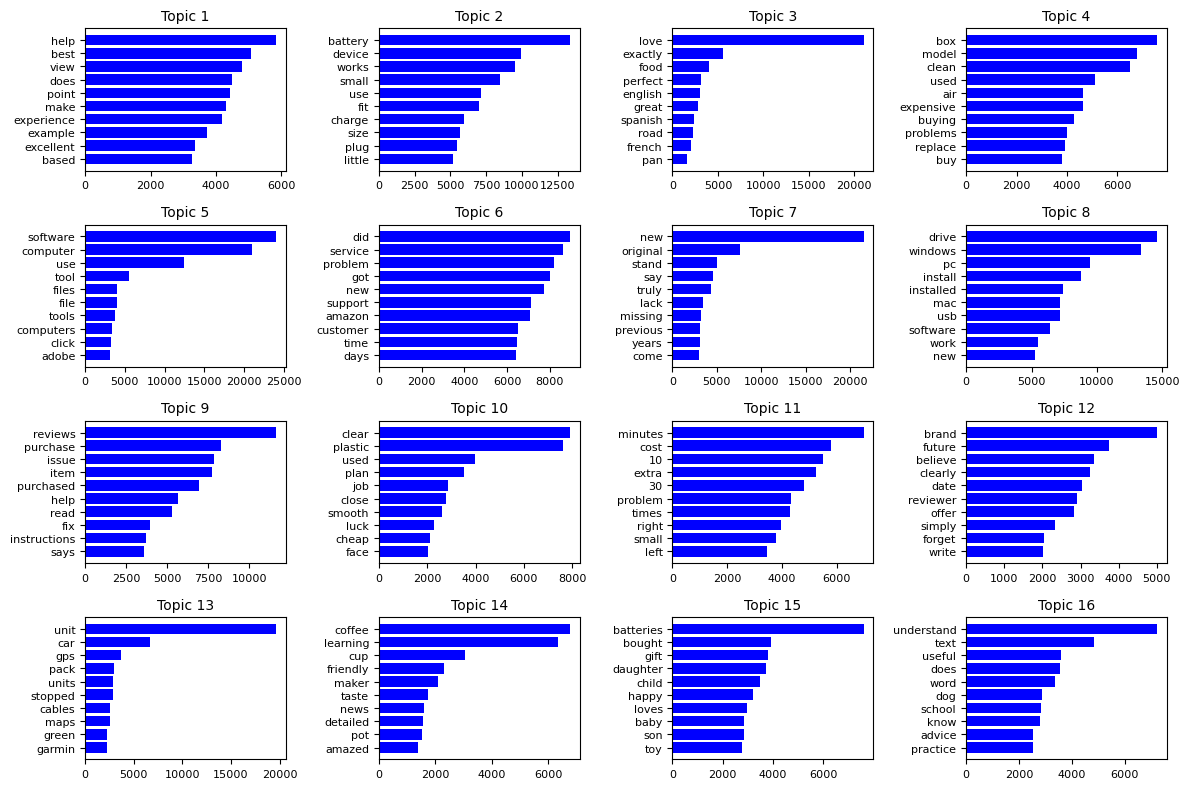

In [189]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_words_per_topic(lda_model, feature_names, num_topics=5, num_words=10):
    """
    Plot top words for each topic in a grid layout with a single consistent color.

    Args:
        lda_model: Trained LDA model.
        feature_names: List of feature names from the vectorizer.
        num_topics: Number of topics to display.
        num_words: Number of top words to display for each topic.
    """
    # Calculate the number of rows needed for 4 columns
    num_columns = 4
    num_rows = (num_topics + num_columns - 1) // num_columns

    # Adjust figure size for compactness
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_[:num_topics]):
        top_words_indices = topic.argsort()[:-num_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        weights = topic[top_words_indices]

        # Use a single consistent color (blue)
        axes[topic_idx].barh(top_words, weights, color="blue")
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=10)
        axes[topic_idx].invert_yaxis()
        axes[topic_idx].tick_params(axis='x', labelsize=8)
        axes[topic_idx].tick_params(axis='y', labelsize=8)

    # Hide any unused subplots
    for idx in range(num_topics, len(axes)):
        axes[idx].axis("off")

    # Adjust layout for a single page
    plt.tight_layout()
    plt.show()

# Example Usage:
plot_top_words_per_topic(lda_model, vocabulary, num_topics=16, num_words=10)


C:\Users\roman\AppData\Local\Temp\ipykernel_14008\3264065918.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_topics)


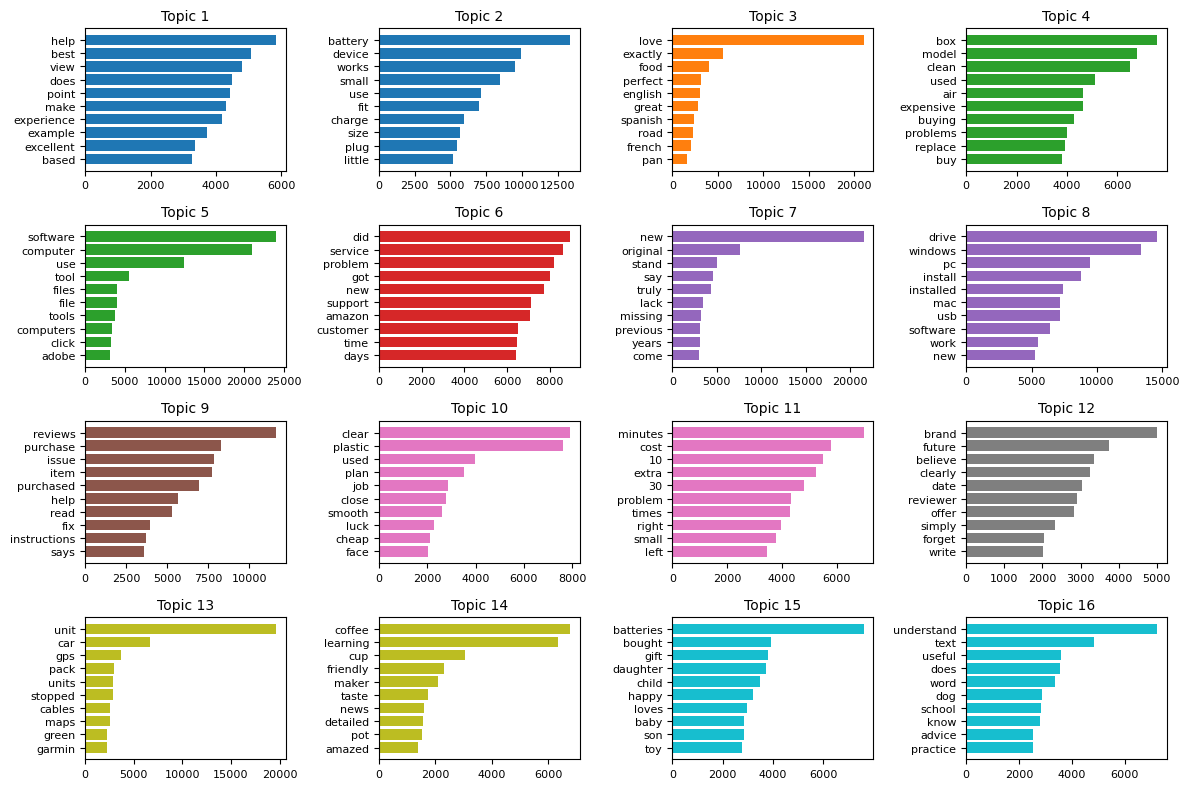

In [192]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

def plot_top_words_per_topic(lda_model, feature_names, num_topics=5, num_words=10):
    """
    Plot top words for each topic in a grid layout with varied colors for subplots.

    Args:
        lda_model: Trained LDA model.
        feature_names: List of feature names from the vectorizer.
        num_topics: Number of topics to display.
        num_words: Number of top words to display for each topic.
    """
    # Calculate the number of rows needed for 4 columns
    num_columns = 4
    num_rows = (num_topics + num_columns - 1) // num_columns

    # Adjust figure size for compactness
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.flatten()

    # Generate a colormap
    colors = cm.get_cmap('tab10', num_topics)

    for topic_idx, topic in enumerate(lda_model.components_[:num_topics]):
        top_words_indices = topic.argsort()[:-num_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        weights = topic[top_words_indices]

        # Use unique colors for each subplot
        axes[topic_idx].barh(top_words, weights, color=colors(topic_idx))
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=10)
        axes[topic_idx].invert_yaxis()
        axes[topic_idx].tick_params(axis='x', labelsize=8)
        axes[topic_idx].tick_params(axis='y', labelsize=8)

    # Hide any unused subplots
    for idx in range(num_topics, len(axes)):
        axes[idx].axis("off")

    # Adjust layout for a single page
    plt.tight_layout()
    plt.show()

# Example Usage:
plot_top_words_per_topic(lda_model, vocabulary, num_topics=16, num_words=10)


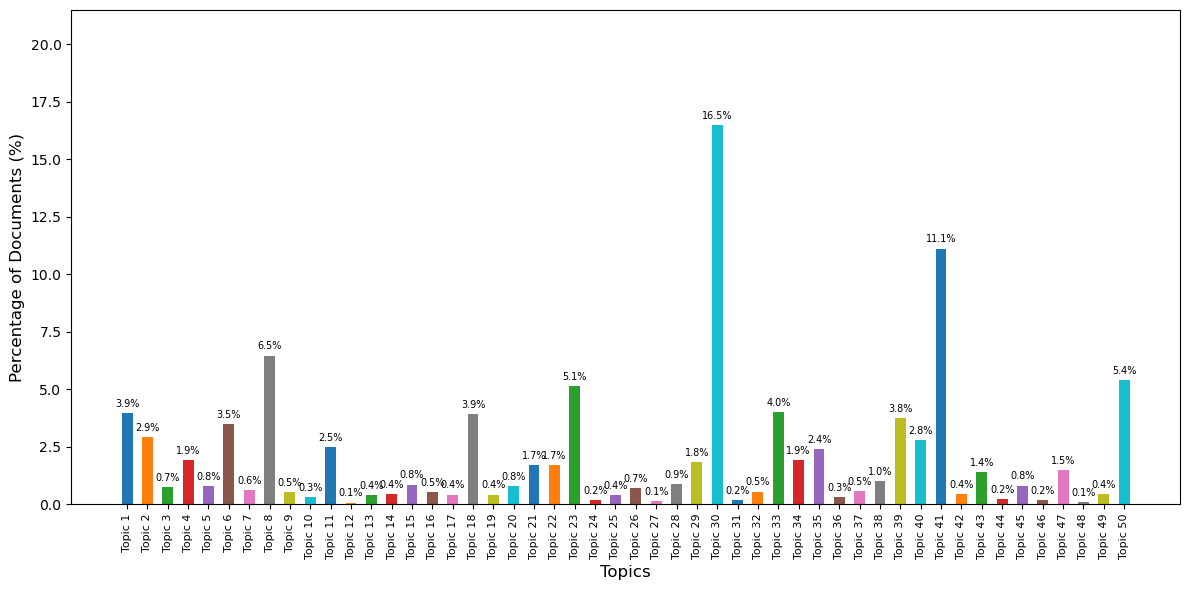

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_topic_proportion_bar(doc_topic_distributions, num_topics=5):
    """
    Plot the proportion of documents dominated by each topic as a bar chart with spacing between bars.

    Args:
        doc_topic_distributions: Per-document topic distributions (array).
        num_topics: Number of topics to display.
    """
    # Count documents by dominant topic
    dominant_topics = np.argmax(doc_topic_distributions, axis=1)
    topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

    # Normalize to percentages
    topic_percentages = (topic_counts / len(doc_topic_distributions)) * 100

    # Create positions for the bars with added spacing
    bar_positions = np.arange(len(topic_percentages.values[:num_topics])) * 1.5

    # Plot bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        bar_positions, 
        topic_percentages.values[:num_topics], 
        color=plt.cm.tab10.colors[:num_topics],
        width=0.8  # Adjust bar width to enhance spacing effect
    )

    # Add labels to the bars
    plt.bar_label(bars, labels=[f"{percentage:.1f}%" for percentage in topic_percentages.values[:num_topics]], padding=3, fontsize=7)

    # Update x-axis with proper topic names
    plt.xticks(bar_positions, [f"Topic {i + 1}" for i in range(num_topics)], rotation=90, fontsize=8)

    # plt.title("Proportion of Documents by Dominant Topic", fontsize=16)
    plt.xlabel("Topics", fontsize=12)
    plt.ylabel("Percentage of Documents (%)", fontsize=12)
    plt.ylim(0, max(topic_percentages.values[:num_topics]) + 5)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/topic_proportion_bar_chart.pdf", format='pdf')
    plt.show()

# Example Usage:
plot_topic_proportion_bar(doc_topic_distributions, num_topics=50)


## Results

In [1]:
import matplotlib.pyplot as plt

In [45]:
# List of queries
queries = [
    "audio quality:poor",
    "wifi signal:strong",
    "gps map:useful",
    "image quality:sharp",
    "mouse button:problem"
]

In [46]:
# Define methods to test
methods = ["method2"]  # OR, AND, OR+AND

In [47]:
# Initialize result storage
evaluation_results = {
    "boolean": [],
    "boolean_rating": [],
    "boolean_semantic": [],
    "topic_modeling": []
}

In [48]:
# Evaluate each query across all methods
for query in queries:
    print(f"Query: {query}")
    aspect1, aspect2_opinion = query.split()
    aspect2, opinion = aspect2_opinion.split(":")
    
    for method in methods:
        # Boolean Search
        boolean_results = boolean_search(aspect1, aspect2, opinion, method)
        evaluation_results["boolean"].append(len(boolean_results))
        
        # Boolean + Ratings
        boolean_rating_results = boolean_rating_search(aspect1, aspect2, opinion, method)
        evaluation_results["boolean_rating"].append(len(boolean_rating_results))
        
        # Boolean + Semantic
        boolean_semantic_results = boolean_semantic_search(aspect1, aspect2, opinion, method)
        evaluation_results["boolean_semantic"].append(len(boolean_semantic_results))
        
        # Topic Modeling
        topic_model_results = topic_model_search(aspect1, aspect2, opinion, method)
        evaluation_results["topic_modeling"].append(len(topic_model_results))
        
        # Print individual results
        # print(f"Method: {method}")
        print(f"  Boolean: {len(boolean_results)}")
        print(f"  Ratings: {len(boolean_rating_results)}")
        print(f"  Semantic: {len(boolean_semantic_results)}")
        print(f"  Topic Modeling: {len(topic_model_results)}")
    print("-" * 50)

Query: audio quality:poor
  Boolean: 128
  Ratings: 3
  Semantic: 24
  Topic Modeling: 9
--------------------------------------------------
Query: wifi signal:strong
  Boolean: 13
  Ratings: 11
  Semantic: 9
  Topic Modeling: 2
--------------------------------------------------
Query: gps map:useful
  Boolean: 91
  Ratings: 60
  Semantic: 31
  Topic Modeling: 1
--------------------------------------------------
Query: image quality:sharp
  Boolean: 189
  Ratings: 149
  Semantic: 25
  Topic Modeling: 491
--------------------------------------------------
Query: mouse button:problem
  Boolean: 245
  Ratings: 0
  Semantic: 122
  Topic Modeling: 1
--------------------------------------------------


In [128]:
queries = [
    "audio quality:poor"
    # "wifi signal:strong",
    # "gps map:useful",
    # "image quality:sharp",
    # "mouse button:problem"
]
methods = ["boolean", "boolean_rating", "boolean_semantic", "topic_modeling"]
# Initialize results for plotting
results_for_plotting = []

In [129]:
# Evaluate each query
for query in queries:
    print(f"Evaluating Query: {query}")
    aspect1, aspect2_opinion = query.split()
    aspect2, opinion = aspect2_opinion.split(":")
    query_results = {"query": query, "method_data": []}

    for method in methods:
        # Simulate retrieval of data from your functions
        retrieved = len(boolean_search(aspect1, aspect2, opinion, "method2"))
        relevant = np.random.randint(0, retrieved + 1)  # Replace with actual count of relevant docs
        precision = relevant / retrieved if retrieved > 0 else 0

        query_results["method_data"].append({
            "method": method,
            "retrieved": retrieved,
            "relevant": relevant,
            "precision": precision
        })
        print(f"Method: {method}, Retrieved: {retrieved}, Relevant: {relevant}, Precision: {precision:.2f}")

    results_for_plotting.append(query_results)
    print("-" * 50)

Evaluating Query: audio quality:poor
Method: boolean, Retrieved: 128, Relevant: 122, Precision: 0.95
Method: boolean_rating, Retrieved: 128, Relevant: 67, Precision: 0.52
Method: boolean_semantic, Retrieved: 128, Relevant: 102, Precision: 0.80
Method: topic_modeling, Retrieved: 128, Relevant: 123, Precision: 0.96
--------------------------------------------------


In [130]:
methods = ["Boolean Search", "Rating Search", "Semantic Search", "Topic Modeling"]

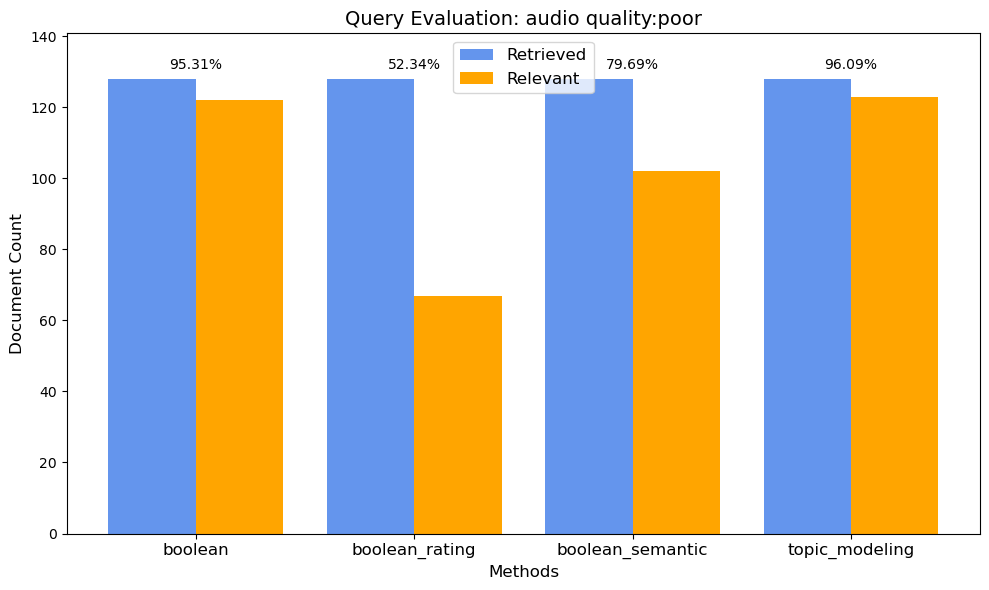

In [133]:
# Determine the maximum y-axis value across all queries for consistent scaling
max_y = max(
    max(data["retrieved"], data["relevant"]) for query_result in results_for_plotting
    for data in query_result["method_data"]
)
max_y = max_y * 1.1  # Add 10% padding for precision text

# Plotting each query
for query_result in results_for_plotting:
    query = query_result["query"]
    method_data = query_result["method_data"]

    # Extract data for plotting
    methods = [data["method"] for data in method_data]
    retrieved = [data["retrieved"] for data in method_data]
    relevant = [data["relevant"] for data in method_data]
    precision = [data["precision"] for data in method_data]

    # Bar Plot
    bar_width = 0.4
    x = np.arange(len(methods))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars for retrieved and relevant
    ax.bar(x - bar_width / 2, retrieved, bar_width, label="Retrieved", color="cornflowerblue")

    ax.bar(x + bar_width / 2, relevant, bar_width, label="Relevant", color="orange")

    # Add precision text on top
    for i in range(len(methods)):
        # Adjust text position based on the bar heights and max_y
        text_position = min(max_y * 0.98, max(retrieved[i], relevant[i]) + (max_y * 0.02))
        ax.text(x[i], text_position,
                f"{precision[i]:.2%}", ha="center", fontsize=10, color="black")

    # Formatting plot
    ax.set_title(f"Query Evaluation: {query}", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, fontsize=12)
    ax.set_xlabel("Methods", fontsize=12)
    ax.set_ylabel("Document Count", fontsize=12)
    ax.set_ylim(0, max_y)  # Set consistent y-axis limit
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/query_evaluation_1.pdf", format='pdf')
    plt.show()


In [115]:
# Testing Boolean Search
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method2 = "method2" # AND operation on all terms

boolean = boolean_search(query_aspect1, query_aspect2, query_opinion, method2)
boolean_rating = boolean_rating_search(query_aspect1, query_aspect2, query_opinion, method2)
boolean_semantic = boolean_semantic_search(query_aspect1, query_aspect2, query_opinion, method2)
topic_model = topic_model_search(query_aspect1, query_aspect2, query_opinion, method2)


print(f"Results: {len(boolean)}")
print(f"Results: {len(boolean_rating)}")
print(f"Results: {len(boolean_semantic)}")
print(f"Results: {len(topic_model)}")


Results: 128
Results: 3
Results: 24
Results: 9


In [124]:
pd.set_option('display.max_colwidth', 200)

# Convert the set of document IDs to a DataFrame
results = df[df['doc_id'].isin(boolean)]

# Print the 'review_text_cleaned' column
print(results['review_text_cleaned'])

print(boolean_rating['review_text_cleaned'])
print(boolean_semantic['review_text_cleaned'])
print(topic_model['review_text_cleaned'])


4053      Well, the concept is great. The visual and audio are very poor quality. I guess we are spoiled with better quality in our gadgets. This reminds me of a new …first time…30 years ago gadget. Im so s...
8050      I traded in my trusty Handspring Visor Pro of 4 years for my new T3. I wasn't interested in the color screen, I was used to weeks of battery life, and it's a premium priced product. However, a fri...
9863      If you were a fan of Anthrax between 1985 and 1991 and stopped listening to them after Persistence of Time, don't waste your money on this. Like everything else that happened to our favorite thras...
10623     After having read many of the reviews about this little nifty machine I decided to give it a try in a direct-sound production as the main recorder for dialog. In order to be compatible with audio ...
12090     I won't belabor the commentsreviews left by others this is an absolutely phenomenal film that deserves a place on the shelf of any Blu-ray player owne

C:\Users\roman\AppData\Local\Temp\ipykernel_31764\845822973.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


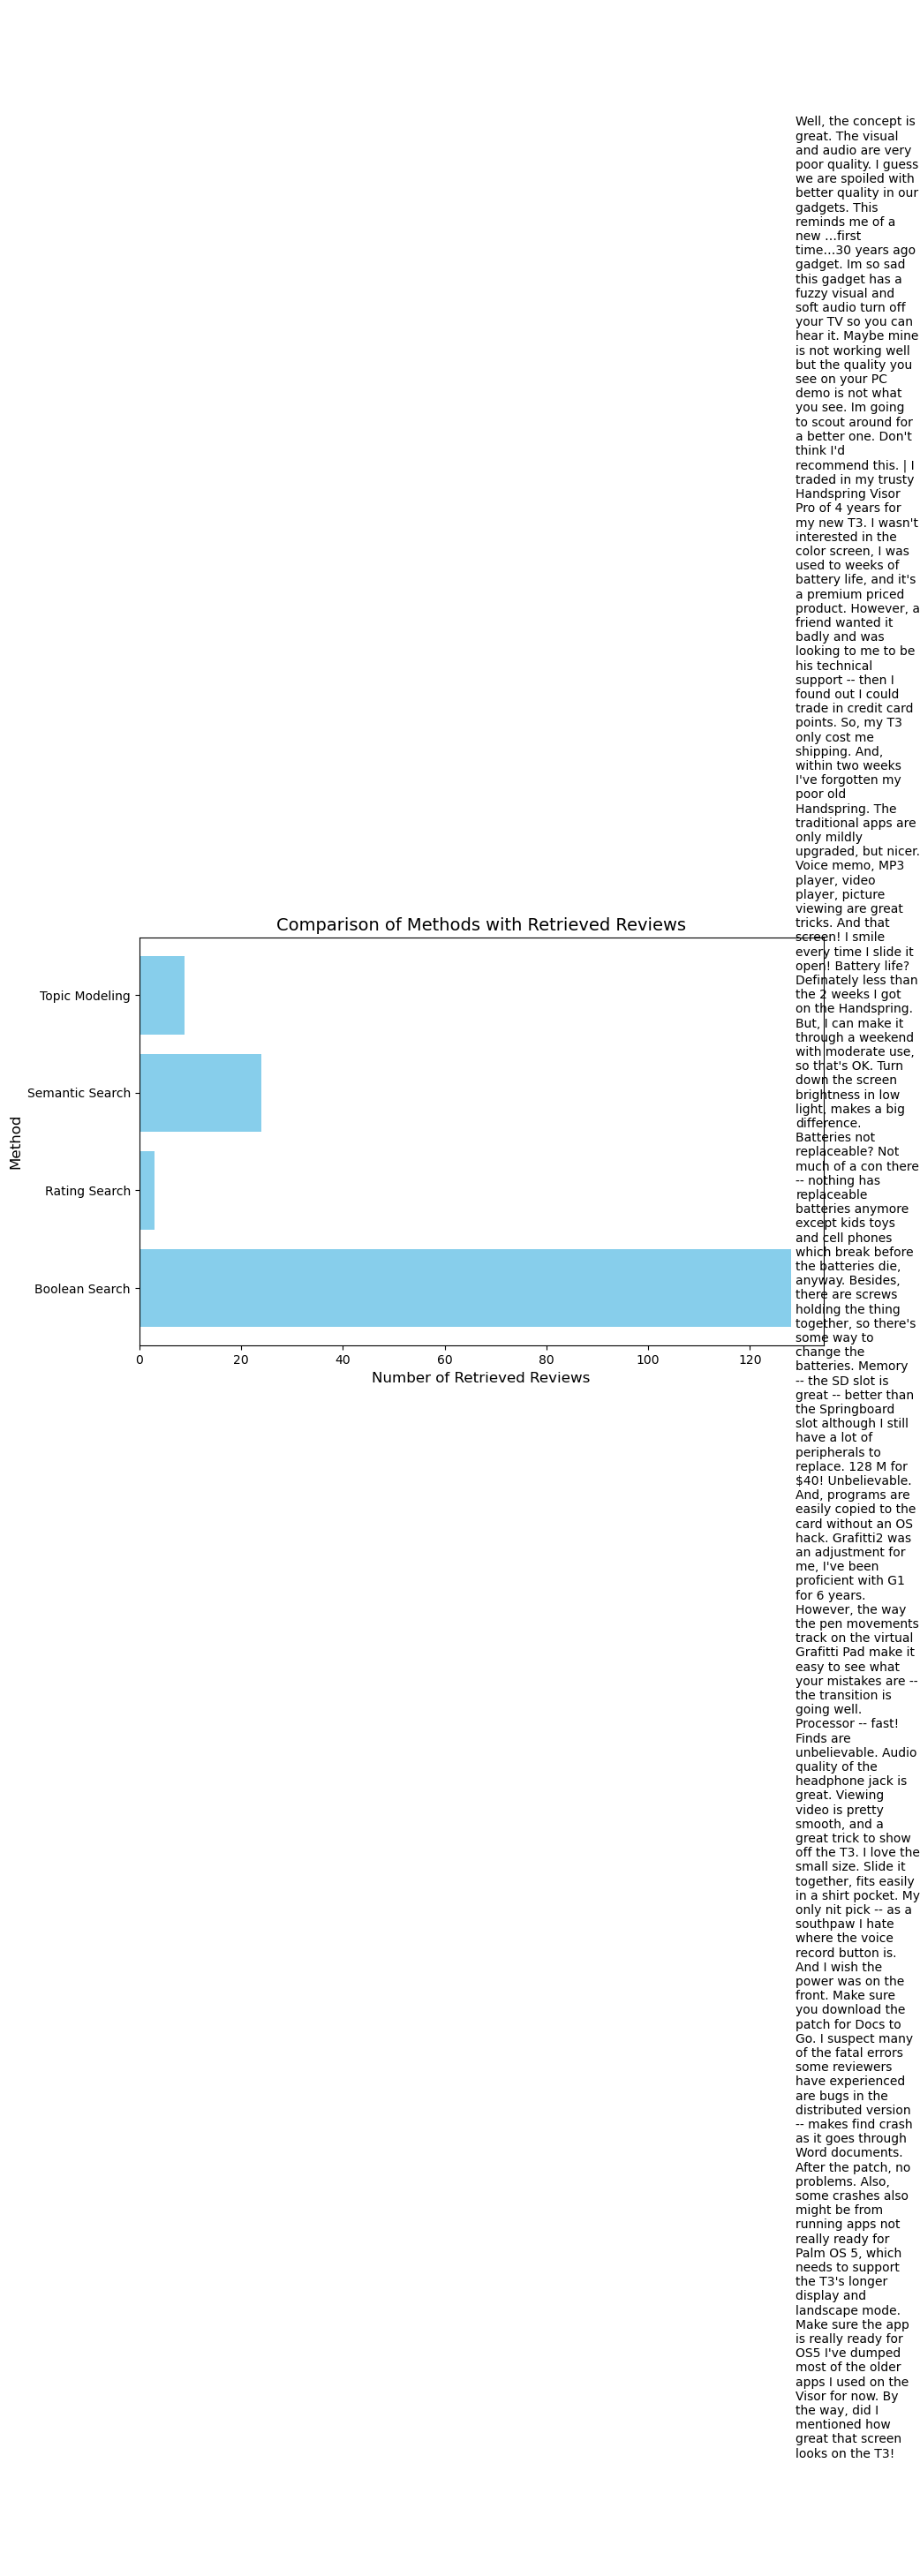

In [108]:
# Sample retrieval process (replace these with actual retrievals)
query_aspect1 = "audio"
query_aspect2 = "quality"
query_opinion = "poor"
method2 = "method2"  # AND operation on all terms

# Perform the searches
boolean = boolean_search(query_aspect1, query_aspect2, query_opinion, method2)
boolean_rating = boolean_rating_search(query_aspect1, query_aspect2, query_opinion, method2)
boolean_semantic = boolean_semantic_search(query_aspect1, query_aspect2, query_opinion, method2)
topic_model = topic_model_search(query_aspect1, query_aspect2, query_opinion, method2)

# Retrieve cleaned reviews
methods = {
    "Boolean Search": boolean,
    "Rating Search": boolean_rating,
    "Semantic Search": boolean_semantic,
    "Topic Modeling": topic_model,
}

# Load review dataset
review_df = pd.read_pickle("../data/reviews_segment_processed.pkl")

# Prepare data for plotting
data = []
for method_name, doc_ids in methods.items():
    cleaned_reviews = review_df[review_df['doc_id'].isin(doc_ids)]['review_text_cleaned'].tolist()
    # Add the first two snippets for the method
    snippets = " | ".join(cleaned_reviews[:2])  # Combine snippets with a separator
    data.append((method_name, len(doc_ids), snippets))

# Convert to DataFrame for easier handling
plot_data = pd.DataFrame(data, columns=["Method", "Retrieved", "Snippets"])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(plot_data["Method"], plot_data["Retrieved"], color="skyblue")
plt.xlabel("Number of Retrieved Reviews", fontsize=12)
plt.ylabel("Method", fontsize=12)
plt.title("Comparison of Methods with Retrieved Reviews", fontsize=14)

# Annotate bars with snippets
for bar, snippet in zip(bars, plot_data["Snippets"]):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, snippet, 
             ha='left', va='center', fontsize=10, color="black", wrap=True)

plt.tight_layout()
plt.show()

## Boolean Search GUI 

In [135]:
import tkinter as tk
from tkinter import scrolledtext
import time  # Import the time module

# Function to search for a word and display results in all three listboxes
def search_word(event=None):  # Add event argument to handle Enter key binding
    query = entry.get().lower()
    terms = query.split()

    # Validate query format
    if len(terms) != 3:
        results_listbox_method1.insert(tk.END, "Invalid query format. Provide exactly 3 terms.")
        return

    aspect1, aspect2, opinion = terms[0], terms[1], terms[2]

    # Perform the Boolean search for each method and measure time
    result_docs = {}
    query_times = {}

    for method in ["method1", "method2", "method3"]:
        start_time = time.time()
        result_docs[method] = boolean_search(aspect1, aspect2, opinion, method)
        query_times[method] = time.time() - start_time

    # Clear previous results in all listboxes
    results_listbox_method1.delete(0, tk.END)
    results_listbox_method2.delete(0, tk.END)
    results_listbox_method3.delete(0, tk.END)

    # Update GUI elements for each method
    update_listbox_and_labels("method1", result_docs, query_times, aspect1, aspect2, opinion)
    update_listbox_and_labels("method2", result_docs, query_times, aspect1, aspect2, opinion)
    update_listbox_and_labels("method3", result_docs, query_times, aspect1, aspect2, opinion)

# Helper to update a specific method's listbox and labels
def update_listbox_and_labels(method, result_docs, query_times, aspect1, aspect2, opinion):
    listbox, total_label, time_label = get_method_widgets(method)

    if result_docs[method]:
        for doc_id in result_docs[method]:
            listbox.insert(tk.END, f"doc_id: {doc_id}")
        total_label.config(text=f"Total Documents: {len(result_docs[method])}")
        time_label.config(text=f"Query Time: {query_times[method]:.4f} seconds")
    else:
        listbox.insert(tk.END, f"No results found for '{aspect1}, {aspect2}, {opinion}' in {method}")
        total_label.config(text="Total Documents: 0")
        time_label.config(text="Query Time: 0.0000 seconds")

# Helper to get widgets associated with each method
def get_method_widgets(method):
    if method == "method1":
        return results_listbox_method1, total_docs_method1_label, query_time_method1_label
    elif method == "method2":
        return results_listbox_method2, total_docs_method2_label, query_time_method2_label
    elif method == "method3":
        return results_listbox_method3, total_docs_method3_label, query_time_method3_label

# Function to display and highlight full document text
def show_full_text(event, listbox, method_name):
    selection = listbox.curselection()
    if selection:
        selected_text = listbox.get(selection[0])
        doc_id = int(selected_text.split(':')[1].strip())  # Extract doc_id

        query = entry.get().lower()
        terms = query.split()
        if len(terms) == 3:
            aspect1, aspect2, opinion = terms
        else:
            return

        # Get document text using doc_id
        doc_text = df[df['doc_id'] == doc_id]['review_text'].values[0]

        # Clear and display text in ScrolledText area
        doc_text_area.delete(1.0, tk.END)
        doc_text_area.insert(tk.INSERT, doc_text)
        highlight_word_in_text(doc_text_area, aspect1, aspect2, opinion)

# Highlight specific terms with colors
def highlight_word_in_text(text_widget, aspect1, aspect2, opinion):
    highlight_term(text_widget, aspect1, "highlight_aspect1", "blue")
    highlight_term(text_widget, aspect2, "highlight_aspect2", "green")
    highlight_term(text_widget, opinion, "highlight_opinion", "orange")

# Helper to highlight a term with a specific color
def highlight_term(text_widget, word, tag_name, color):
    start_index = "1.0"
    while True:
        start_index = text_widget.search(word, start_index, stopindex=tk.END, nocase=True)
        if not start_index:
            break
        end_index = f"{start_index}+{len(word)}c"
        text_widget.tag_add(tag_name, start_index, end_index)
        start_index = end_index
    text_widget.tag_config(tag_name, background=color, foreground="black")

# Create the GUI
root = tk.Tk()
root.title("Boolean Search for Aspects and Opinion")
root.geometry("800x800")
root.configure(bg="#f2f2f2")

# Entry and button
entry_label = tk.Label(root, text="Search for a word (aspect1, aspect2, opinion):", font=("Arial", 12, "bold"), bg="#f2f2f2")
entry_label.pack(pady=5)
entry = tk.Entry(root, width=40, font=("Arial", 12), bg="#e6e6e6", fg="black")
entry.pack(pady=10)
entry.bind("<Return>", search_word)
search_button = tk.Button(root, text="Search", font=("Arial", 10, "bold"), bg="#4CAF50", fg="white", command=search_word)
search_button.pack(pady=10)

# Frames and widgets for results
results_frame = tk.Frame(root, bg="#f2f2f2")
results_frame.pack(pady=10)

# Listboxes and labels for method1
method1_label = tk.Label(results_frame, text="Method 1 (OR on all terms):", font=("Arial", 12, "bold"), bg="#f2f2f2")
method1_label.grid(row=0, column=0, padx=10)
results_listbox_method1 = tk.Listbox(results_frame, width=20, height=10, font=("Arial", 12), bg="#e6e6e6", fg="black")
results_listbox_method1.grid(row=1, column=0, padx=10)
results_listbox_method1.bind('<<ListboxSelect>>', lambda event: show_full_text(event, results_listbox_method1, "method1"))
total_docs_method1_label = tk.Label(results_frame, text="Total Documents: 0", font=("Arial", 12), bg="#f2f2f2")
total_docs_method1_label.grid(row=2, column=0, padx=10)
query_time_method1_label = tk.Label(results_frame, text="Query Time: 0.0000 seconds", font=("Arial", 12), bg="#f2f2f2")
query_time_method1_label.grid(row=3, column=0, padx=10)

# Repeat for method2 and method3
method2_label = tk.Label(results_frame, text="Method 2 (AND on all terms):", font=("Arial", 12, "bold"), bg="#f2f2f2")
method2_label.grid(row=0, column=1, padx=10)
results_listbox_method2 = tk.Listbox(results_frame, width=20, height=10, font=("Arial", 12), bg="#e6e6e6", fg="black")
results_listbox_method2.grid(row=1, column=1, padx=10)
results_listbox_method2.bind('<<ListboxSelect>>', lambda event: show_full_text(event, results_listbox_method2, "method2"))
total_docs_method2_label = tk.Label(results_frame, text="Total Documents: 0", font=("Arial", 12), bg="#f2f2f2")
total_docs_method2_label.grid(row=2, column=1, padx=10)
query_time_method2_label = tk.Label(results_frame, text="Query Time: 0.0000 seconds", font=("Arial", 12), bg="#f2f2f2")
query_time_method2_label.grid(row=3, column=1, padx=10)

method3_label = tk.Label(results_frame, text="Method 3 (OR on aspects, AND on opinion):", font=("Arial", 12, "bold"), bg="#f2f2f2")
method3_label.grid(row=0, column=2, padx=10)
results_listbox_method3 = tk.Listbox(results_frame, width=20, height=10, font=("Arial", 12), bg="#e6e6e6", fg="black")
results_listbox_method3.grid(row=1, column=2, padx=10)
results_listbox_method3.bind('<<ListboxSelect>>', lambda event: show_full_text(event, results_listbox_method3, "method3"))
total_docs_method3_label = tk.Label(results_frame, text="Total Documents: 0", font=("Arial", 12), bg="#f2f2f2")
total_docs_method3_label.grid(row=2, column=2, padx=10)
query_time_method3_label = tk.Label(results_frame, text="Query Time: 0.0000 seconds", font=("Arial", 12), bg="#f2f2f2")
query_time_method3_label.grid(row=3, column=2, padx=10)

doc_text_label = tk.Label(root, text="Full Document Text:", font=("Arial", 12, "bold"), bg="#f2f2f2")
doc_text_label.pack(pady=5)
doc_text_area = scrolledtext.ScrolledText(root, width=100, height=15, font=("Arial", 10), bg="#e6e6e6", fg="black")
doc_text_area.pack(pady=10)

root.mainloop()

## Project Search Engine

In [134]:
import tkinter as tk
from tkinter import scrolledtext
import time

# Function to search for a word and display results for all methods
def search_word(event=None):
    query = entry.get().lower()
    terms = query.split()

    # Validate query format
    if len(terms) != 3:
        for method in methods.keys():
            results_listboxes[method].insert(tk.END, "Invalid query format. Provide exactly 3 terms.")
        return

    aspect1, aspect2, opinion = terms

    # Perform search for each method and measure time
    result_docs = {}
    query_times = {}

    for method in methods.keys():
        start_time = time.time()
        if method == "boolean_rating_search":
            result_docs[method] = list(boolean_rating_search(aspect1, aspect2, opinion, "method2")["doc_id"])  # Extract doc_id
        elif method == "boolean_semantic_search":
            result_docs[method] = list(boolean_semantic_search(aspect1, aspect2, opinion, "method2")["doc_id"])  # Extract doc_id
        elif method == "topic_model_search":
            result_docs[method] = list(topic_model_search(aspect1, aspect2, opinion, "method2")["doc_id"])  # Extract doc_id
        else:  # Regular Boolean search
            result_docs[method] = list(boolean_search(aspect1, aspect2, opinion, "method2"))
        query_times[method] = time.time() - start_time

    # Clear and update results for each method
    for method, listbox in results_listboxes.items():
        listbox.delete(0, tk.END)
        update_listbox_and_labels(method, result_docs, query_times, aspect1, aspect2, opinion)

# Helper to update a specific method's listbox and labels
def update_listbox_and_labels(method, result_docs, query_times, aspect1, aspect2, opinion):
    listbox = results_listboxes[method]
    total_label = total_docs_labels[method]
    time_label = query_time_labels[method]

    if len(result_docs[method]) > 0:  # Check if there are results
        for doc_id in result_docs[method]:
            listbox.insert(tk.END, f"doc_id: {doc_id}")
        total_label.config(text=f"Total Documents: {len(result_docs[method])}")
        time_label.config(text=f"Query Time: {query_times[method]:.4f} seconds")
    else:
        listbox.insert(tk.END, f"No results found for '{aspect1}, {aspect2}, {opinion}' in {methods[method]}")
        total_label.config(text="Total Documents: 0")
        time_label.config(text="Query Time: 0.0000 seconds")

# Function to display and highlight full document text
def show_full_text(event, method_name):
    listbox = results_listboxes[method_name]
    selection = listbox.curselection()
    if selection:
        selected_text = listbox.get(selection[0])
        try:
            # Extract doc_id safely by checking the format
            if "doc_id:" in selected_text:
                doc_id = int(selected_text.split(':')[1].strip())  # Extract doc_id
            else:
                raise ValueError(f"Invalid format: {selected_text}")

            # Get the document text using the doc_id
            doc_text = df.loc[df['doc_id'] == doc_id, 'review_text_cleaned'].values[0]

            # Display and highlight the text
            doc_text_area.delete(1.0, tk.END)
            doc_text_area.insert(tk.INSERT, doc_text)
            highlight_word_in_text(doc_text_area, entry.get().split()[0], entry.get().split()[1], entry.get().split()[2])
        except Exception as e:
            doc_text_area.delete(1.0, tk.END)
            doc_text_area.insert(tk.INSERT, f"Error retrieving text for doc_id: {e}")

# Highlight specific terms
def highlight_word_in_text(text_widget, aspect1, aspect2, opinion):
    highlight_term(text_widget, aspect1, "highlight_aspect1", "blue")
    highlight_term(text_widget, aspect2, "highlight_aspect2", "green")
    highlight_term(text_widget, opinion, "highlight_opinion", "orange")

# Helper to highlight terms
def highlight_term(text_widget, word, tag_name, color):
    start_index = "1.0"
    while True:
        start_index = text_widget.search(word, start_index, stopindex=tk.END, nocase=True)
        if not start_index:
            break
        end_index = f"{start_index}+{len(word)}c"
        text_widget.tag_add(tag_name, start_index, end_index)
        start_index = end_index
    text_widget.tag_config(tag_name, background=color, foreground="black")

# Define methods
methods = {
    "boolean_search": "Boolean Search",
    "boolean_rating_search": "Boolean + Ratings",
    "boolean_semantic_search": "Boolean + Semantic",
    "topic_model_search": "Topic Modeling",
}

# Create GUI
root = tk.Tk()
root.title("Advanced Boolean Search")
root.geometry("1200x900")
root.configure(bg="#f2f2f2")

# Input entry and search button
entry_label = tk.Label(root, text="Search Query (aspect1, aspect2, opinion):", font=("Arial", 12, "bold"), bg="#f2f2f2")
entry_label.pack(pady=5)
entry = tk.Entry(root, width=50, font=("Arial", 12), bg="#e6e6e6", fg="black")
entry.pack(pady=10)
entry.bind("<Return>", search_word)
search_button = tk.Button(root, text="Search", font=("Arial", 10, "bold"), bg="#4CAF50", fg="white", command=search_word)
search_button.pack(pady=10)

# Results frame
results_frame = tk.Frame(root, bg="#f2f2f2")
results_frame.pack(pady=10)

# Dynamically create widgets for each method
results_listboxes = {}
total_docs_labels = {}
query_time_labels = {}

for idx, (method, description) in enumerate(methods.items()):
    method_label = tk.Label(results_frame, text=f"{description}:", font=("Arial", 12, "bold"), bg="#f2f2f2")
    method_label.grid(row=0, column=idx, padx=10)

    listbox = tk.Listbox(results_frame, width=25, height=15, font=("Arial", 12), bg="#e6e6e6", fg="black")
    listbox.grid(row=1, column=idx, padx=10)
    listbox.bind('<<ListboxSelect>>', lambda event, m=method: show_full_text(event, m))
    results_listboxes[method] = listbox

    total_label = tk.Label(results_frame, text="Total Documents: 0", font=("Arial", 12), bg="#f2f2f2")
    total_label.grid(row=2, column=idx, padx=10)
    total_docs_labels[method] = total_label

    time_label = tk.Label(results_frame, text="Query Time: 0.0000 seconds", font=("Arial", 12), bg="#f2f2f2")
    time_label.grid(row=3, column=idx, padx=10)
    query_time_labels[method] = time_label

# Full document text area
doc_text_label = tk.Label(root, text="Full Document Text:", font=("Arial", 12, "bold"), bg="#f2f2f2")
doc_text_label.pack(pady=5)
doc_text_area = scrolledtext.ScrolledText(root, width=120, height=15, font=("Arial", 10), bg="#e6e6e6", fg="black")
doc_text_area.pack(pady=10)

root.mainloop()

## Beta

In [ ]:
import tkinter as tk
from tkinter import scrolledtext
import time

# Function to search for a word and display results for all methods
def search_word(event=None):
    query = entry.get().lower()
    terms = query.split()

    # Validate query format
    if len(terms) != 3:
        for method in methods.keys():
            results_listboxes[method].insert(tk.END, "Invalid query format. Provide exactly 3 terms.")
        return

    # Save the query to the history listbox if it's not already there
    if query not in query_history:
        query_history.append(query)
        query_listbox.insert(tk.END, query)

    aspect1, aspect2, opinion = terms

    # Perform search for each method and measure time
    result_docs = {}
    query_times = {}

    for method in methods.keys():
        start_time = time.time()
        if method == "boolean_rating_search":
            result_docs[method] = list(boolean_rating_search(aspect1, aspect2, opinion, "method2")["doc_id"])
        elif method == "boolean_semantic_search":
            result_docs[method] = list(boolean_semantic_search(aspect1, aspect2, opinion, "method2")["doc_id"])
        elif method == "topic_model_search":
            result_docs[method] = list(topic_model_search(aspect1, aspect2, opinion, "method2")["doc_id"])
        else:
            result_docs[method] = list(boolean_search(aspect1, aspect2, opinion, "method2"))
        query_times[method] = time.time() - start_time

    # Clear and update results for each method
    for method, listbox in results_listboxes.items():
        listbox.delete(0, tk.END)
        update_listbox_and_labels(method, result_docs, query_times, aspect1, aspect2, opinion)

# Helper to update a specific method's listbox and labels
def update_listbox_and_labels(method, result_docs, query_times, aspect1, aspect2, opinion):
    listbox = results_listboxes[method]
    total_label = total_docs_labels[method]
    time_label = query_time_labels[method]

    if len(result_docs[method]) > 0:
        for doc_id in result_docs[method]:
            listbox.insert(tk.END, f"doc_id: {doc_id}")
        total_label.config(text=f"Total Documents: {len(result_docs[method])}")
        time_label.config(text=f"Query Time: {query_times[method]:.4f} seconds")
    else:
        listbox.insert(tk.END, f"No results found for '{aspect1}, {aspect2}, {opinion}' in {methods[method]}")
        total_label.config(text="Total Documents: 0")
        time_label.config(text="Query Time: 0.0000 seconds")

# Function to display and highlight full document text
def show_full_text(event, method_name):
    listbox = results_listboxes[method_name]
    selection = listbox.curselection()
    if selection:
        selected_text = listbox.get(selection[0])
        try:
            if "doc_id:" in selected_text:
                doc_id = int(selected_text.split(':')[1].strip())
            else:
                raise ValueError(f"Invalid format: {selected_text}")

            doc_text = df.loc[df['doc_id'] == doc_id, 'review_text_cleaned'].values[0]

            doc_text_area.delete(1.0, tk.END)
            doc_text_area.insert(tk.INSERT, doc_text)
            highlight_word_in_text(doc_text_area, entry.get().split()[0], entry.get().split()[1], entry.get().split()[2])
        except Exception as e:
            doc_text_area.delete(1.0, tk.END)
            doc_text_area.insert(tk.INSERT, f"Error retrieving text for doc_id: {e}")

# Highlight specific terms
def highlight_word_in_text(text_widget, aspect1, aspect2, opinion):
    highlight_term(text_widget, aspect1, "highlight_aspect1", "blue")
    highlight_term(text_widget, aspect2, "highlight_aspect2", "green")
    highlight_term(text_widget, opinion, "highlight_opinion", "orange")

# Helper to highlight terms
def highlight_term(text_widget, word, tag_name, color):
    start_index = "1.0"
    while True:
        start_index = text_widget.search(word, start_index, stopindex=tk.END, nocase=True)
        if not start_index:
            break
        end_index = f"{start_index}+{len(word)}c"
        text_widget.tag_add(tag_name, start_index, end_index)
        start_index = end_index
    text_widget.tag_config(tag_name, background=color, foreground="black")

# Function to handle query selection from the history listbox
def select_query(event):
    selection = query_listbox.curselection()
    if selection:
        selected_query = query_listbox.get(selection[0])
        entry.delete(0, tk.END)
        entry.insert(0, selected_query)
        search_word()

# Define methods
methods = {
    "boolean_search": "Boolean Search",
    "boolean_rating_search": "Boolean + Ratings",
    "boolean_semantic_search": "Boolean + Semantic",
    "topic_model_search": "Topic Modeling",
}

# Create GUI
root = tk.Tk()
root.title("Advanced Boolean Search")
root.geometry("1400x900")
root.configure(bg="#f2f2f2")

# Main layout frames
top_frame = tk.Frame(root, bg="#f2f2f2")
top_frame.grid(row=0, column=0, columnspan=2, pady=10)

query_history_frame = tk.Frame(root, bg="#f2f2f2")
query_history_frame.grid(row=1, column=0, sticky="n", padx=10, pady=10)

results_frame = tk.Frame(root, bg="#f2f2f2")
results_frame.grid(row=1, column=1, padx=10, pady=10)

bottom_frame = tk.Frame(root, bg="#f2f2f2")
bottom_frame.grid(row=2, column=0, columnspan=2, pady=10)

# Input entry and search button
entry_label = tk.Label(top_frame, text="Search Query (aspect1, aspect2, opinion):", font=("Arial", 12, "bold"), bg="#f2f2f2")
entry_label.pack(pady=5)
entry = tk.Entry(top_frame, width=50, font=("Arial", 12), bg="#e6e6e6", fg="black")
entry.pack(pady=5)
entry.bind("<Return>", search_word)
search_button = tk.Button(top_frame, text="Search", font=("Arial", 10, "bold"), bg="#4CAF50", fg="white", command=search_word)
search_button.pack(pady=5)

# Query history frame
query_listbox_label = tk.Label(query_history_frame, text="Saved Queries:", font=("Arial", 12, "bold"), bg="#f2f2f2")
query_listbox_label.pack()
query_listbox = tk.Listbox(query_history_frame, width=30, height=20, font=("Arial", 12), bg="#e6e6e6", fg="black")
query_listbox.pack()
query_listbox.bind('<<ListboxSelect>>', select_query)
query_history = []

# Results frame
results_listboxes = {}
total_docs_labels = {}
query_time_labels = {}

for idx, (method, description) in enumerate(methods.items()):
    method_label = tk.Label(results_frame, text=f"{description}:", font=("Arial", 12, "bold"), bg="#f2f2f2")
    method_label.grid(row=0, column=idx, padx=10)

    listbox = tk.Listbox(results_frame, width=25, height=15, font=("Arial", 12), bg="#e6e6e6", fg="black")
    listbox.grid(row=1, column=idx, padx=10)
    listbox.bind('<<ListboxSelect>>', lambda event, m=method: show_full_text(event, m))
    results_listboxes[method] = listbox

    total_label = tk.Label(results_frame, text="Total Documents: 0", font=("Arial", 12), bg="#f2f2f2")
    total_label.grid(row=2, column=idx, padx=10)
    total_docs_labels[method] = total_label

    time_label = tk.Label(results_frame, text="Query Time: 0.0000 seconds", font=("Arial", 12), bg="#f2f2f2")
    time_label.grid(row=3, column=idx, padx=10)
    query_time_labels[method] = time_label

# Full document text area
doc_text_label = tk.Label(bottom_frame, text="Full Document Text:", font=("Arial", 12, "bold"), bg="#f2f2f2")
doc_text_label.pack(pady=5)
doc_text_area = scrolledtext.ScrolledText(bottom_frame, width=140, height=15, font=("Arial", 10), bg="#e6e6e6", fg="black")
doc_text_area.pack(pady=10)

root.mainloop()


## Issues

In [ ]:
def compare_queries(query1, query2):
    aspect1_1, aspect2_1, opinion1 = query1.split()
    aspect1_2, aspect2_2, opinion2 = query2.split()

    print(f"Query 1: {query1}")
    print("Boolean Search:", len(boolean_search(aspect1_1, aspect2_1, opinion1, "method2")))
    print("Boolean + Ratings:", len(boolean_rating_search(aspect1_1, aspect2_1, opinion1, "method2")))
    print("Boolean + Semantic:", len(boolean_semantic_search(aspect1_1, aspect2_1, opinion1, "method2")))
    print("Topic Modeling:", len(topic_model_search(aspect1_1, aspect2_1, opinion1, "method2")))

    print(f"\nQuery 2: {query2}")
    print("Boolean Search:", len(boolean_search(aspect1_2, aspect2_2, opinion2, "method2")))
    print("Boolean + Ratings:", len(boolean_rating_search(aspect1_2, aspect2_2, opinion2, "method2")))
    print("Boolean + Semantic:", len(boolean_semantic_search(aspect1_2, aspect2_2, opinion2, "method2")))
    print("Topic Modeling:", len(topic_model_search(aspect1_2, aspect2_2, opinion2, "method2")))


In [ ]:
compare_queries("phone screen issues", "phone screen issue")